<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/RadiopharmaceuticalNetworkALNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Packages**

In [ ]:
!pip install geopandas contextily shapely pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.9 MB/s eta 0:00:00


In [ ]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import itertools

import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import pandas as pd
import numpy as np

import heapq
from collections import defaultdict
import time

In [ ]:
from collections import defaultdict
from copy import deepcopy

# **Initial Parameters**

In [20]:
hospitals = {
    "Michigan Diagnostics Center": (42.48853947067958, -83.10526194019599),
    "Nuclear Medicine PET Scan at University Hospital": (42.373423665779875, -83.74705677218591),
    "Regional Medical Imaging Southgate": (42.25969201846909, -83.17027457939628),
    "Beaumont PET/CT St. Clair Shores": (42.56791387603854, -82.8846300648719),
    "Regional Medical Imaging Novi": (42.49902362908627, -83.42865686601002),
    "Henry Ford Radiology and Imaging - Macomb Hospital": (42.64671830391097, -82.96015224192095),
    "Computed Tomography (CT/CAT scan) at Livonia Center for Specialty Care": (42.452871313282124, -83.43988814124502),
    "Computed Tomography (CAT/CT scan) at East Ann Arbor Health and Geriatrics Center": (42.34030658958308, -83.677349389071),
    "Synergy MRI: Royal Oak - Pure Open MRI": (42.50612096423798, -83.14466604935329),
    "Michigan Resonance Imaging": (42.6915481520167, -83.23932965490553),
    "Computed Tomography (CAT/CT scan) at Canton Health Center": (42.35216501570914, -83.48962664585721),
    "Therma-Scan of Michigan, LLC": (42.53450224783935, -83.28906815951773),
    "Life Scan Imaging Corporation": (42.55223400342188, -83.01309968231458),
    "Scan Clear MRI": (42.639636951333856, -82.96175670981167),
    "McLaren Clarkston - Diagnostic Imaging": (42.749307331742, -83.38212729717925),
    "Corewell Health William Beaumont University Hospital Imaging Center - 3581 W 13 Mile Rd": (42.53686677288904, -83.19761348974691),
    "Corewell Health Farmington Hills Hospital Cancer PET - 27900 Grand River Ave": (42.46115756857247, -83.32917985678563),
    "Michigan Diagnostics": (42.56405237592633, -83.18156881083976),
    "University of Michigan Department of Radiology": (42.31065073827846, -83.7367147010275),
    "Magnetic Resonance Imaging (MRI) at University Hospital": (42.31302372082438, -83.74313257259035),
    "University of Michigan Radiology Department": (42.3308182381527, -83.66451364594526),
    "Henry Ford Radiology and Imaging - Henry Ford Hospital": (42.39483682739532, -83.09332307685038),
    "Cat Scan Center-Clarkston": (42.75048553064453, -83.42223899444716),
    "Karmanos Cancer Institute": (42.37587515709506, -83.0548158474732),
    "Corewell Health William Beaumont University Hospital Imaging Center (North) - 3601 West 13 Mile Rd": (42.54750602768598, -83.18798668240262),
    "University of Michigan Hospital": (42.3082776662676, -83.73029682946462),
    "West Ann Arbor Health Center": (42.30617469480637, -83.81869373445174),
    "Corewell Health Farmington Hills Hospital": (42.492773027416945, -83.32430899777493),
    "U of M nuclear medicine": (42.30567431128067, -83.73610211287075),
    "Xoran Technologies, LLC.": (42.2347479291253, -83.74979481977397),
    "H C S Group": (42.38891163244826, -83.47602561421753),
    "Brighton Center for Specialty Care": (42.5569552581989, -83.78832668728445),
    "Barbara Ann Karmanos Cancer Institute - Lawrence and Idell Weisberg Cancer Treatment Center": (42.53715336348327, -83.34675344872672),
    "Henry Ford Cancer - Detroit": (42.38923356016813, -83.08820419968758),
    "Bionicc Body Screening": (42.50779307035835, -83.26398543939487),
    "Medical Scan Inc": (42.60591583149083, -83.15000229177215),
    "Henry Ford Medical Center - Sterling Heights": (42.57052850357885, -83.07172470846498),
    "Corewell Health Dearborn Hospital": (42.31616234192726, -83.20218734731026),
    "University of Michigan Medical Center": (42.30302607557066, -83.73009342374314),
    "Henry Ford Hospital": (42.39578802444869, -83.07850907813186),
    "Children's Hospital of Michigan": (42.37245750030311, -83.0524165503628),
    "DMC Detroit Receiving Hospital": (42.371442933019594, -83.0524165503628),
    "McLaren Clarkston": (42.75377544900855, -83.36983337813187),
    "Huron Gastro Ann Arbor": (42.28356418243363, -83.6595742965488),
}

depot = {
    "EHMET health": (42.42980168639475, -83.52695942935674)
}

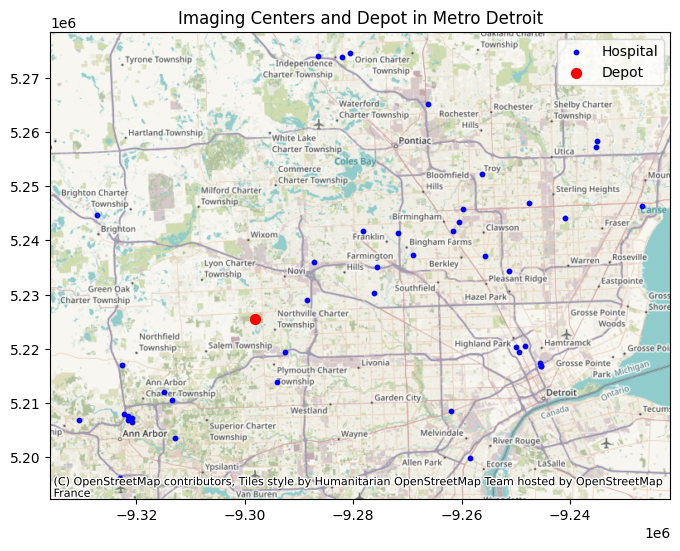

In [21]:
# 1. Build GeoDataFrames
hospital_points = []
for name, (lat, lon) in hospitals.items():
    # Note: geometry expects (longitude, latitude)
    hospital_points.append([name, Point(lon, lat)])

hospitals_gdf = gpd.GeoDataFrame(
    hospital_points,
    columns=["Name", "geometry"],
    crs="EPSG:4326"
)

depot_points = []
for name, (lat, lon) in depot.items():
    depot_points.append([name, Point(lon, lat)])

depot_gdf = gpd.GeoDataFrame(
    depot_points,
    columns=["Name", "geometry"],
    crs="EPSG:4326"
)

# 2. Reproject to Web Mercator
hospitals_3857 = hospitals_gdf.to_crs(epsg=3857)
depot_3857 = depot_gdf.to_crs(epsg=3857)

# 3. Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot hospitals in blue
hospitals_3857.plot(
    ax=ax,
    color='blue',
    markersize=10,
    label='Hospital'
)

# Plot depot in red
depot_3857.plot(
    ax=ax,
    color='red',
    markersize=50,
    label='Depot'
)

# Add a basemap behind it
cx.add_basemap(ax, crs=hospitals_3857.crs)

ax.legend()
plt.title("Imaging Centers and Depot in Metro Detroit")
plt.show()

In [22]:
# Distance Matrix Generator
nodes = {**depot, **hospitals} # Ensures depot is node 0

# Create a list of node names
node_names = list(nodes.keys())

# Define the haversine function to calculate distances
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points on Earth."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    km = 6371 * c  # Earth's radius in km
    return km

# Initialize an empty DataFrame for the distance matrix
distances = pd.DataFrame(index=node_names, columns=node_names, dtype=float)
distance_matrix_np = distances.to_numpy()

# Compute pairwise distances using the haversine formula
for name1 in node_names:
    lat1, lon1 = nodes[name1]
    for name2 in node_names:
        lat2, lon2 = nodes[name2]
        distances.loc[name1, name2] = haversine(lon1, lat1, lon2, lat2)

# Calculates the travel times and cost matrices
vehicle_speed = 60 # km/hour

t = (distances / vehicle_speed) * 60  # travel times in minutes
c = distances * 0.093  # travel costs

t_matrix_np = t.to_numpy()
c_matrix_np = c.to_numpy()

In [23]:
V = range(45)  # nodes including depot, 0 is depot
V_star = range(1, 45)  # nodes excluding depot

K = range(7)
vehicle_speed = 60  # vehicle speed in km/h

In [24]:
# Time window parameters (converted into minutes)
# First element of array is for the depot
a = [0, 480, 0, 450, 420, 390, 0, 480, 480, 450, 0, 480, 540, 0, 510, 420, 420, 480, 480, 480, 0, 0, 390, 0, 0, 480, 0, 420, 0, 0, 540, 0, 420, 420, 420, 540, 0, 0, 0, 0, 0, 0, 0, 0, 480]
b = [1440, 1020, 1440, 1170, 960, 1320, 1440, 990, 990, 1080, 1440, 990, 1020, 1440, 1020, 1110, 1020, 720, 1020, 1020, 1440, 1440, 1350, 1440, 1440, 1020, 1440, 1140, 1440, 1440, 1020, 1440, 1140, 1020, 1140, 1080, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1020]
s = [0] + [30] * (len(a) - 1) # Assume 30 min service per customer

num_customers = len(a) - 1
d = [0] + list(np.random.randint(1, 16, size=num_customers))
p = [0] + list(np.random.randint(1, 16, size=num_customers))

num_vehicles = 7
Q = list(np.random.randint(47, 114, size=num_vehicles))

cost_factor = 2.5
fixed_costs = [round(q * cost_factor, 2) for q in Q]

# print d and p in organized form
print(f"{'Customer':>8} | {'Delivery (d)':>12} | {'Pickup (p)':>10}")
print("-" * 36)
for i in range(1, len(d)):  # Skip index 0 (depot)
    print(f"{i:>8} | {d[i]:>12} | {p[i]:>10}")

Customer | Delivery (d) | Pickup (p)
------------------------------------
       1 |           14 |         10
       2 |           12 |          6
       3 |           10 |         13
       4 |            9 |          1
       5 |            9 |          9
       6 |            5 |          7
       7 |            1 |          4
       8 |            4 |          1
       9 |            9 |          1
      10 |            8 |          7
      11 |            3 |          3
      12 |            7 |         14
      13 |            8 |         15
      14 |            4 |          4
      15 |           15 |         10
      16 |            7 |          6
      17 |           12 |          8
      18 |           11 |          7
      19 |            3 |         10
      20 |            1 |         12
      21 |           14 |         12
      22 |            5 |          6
      23 |            8 |         14
      24 |            6 |          6
      25 |            8 |          2
 

In [25]:
import heapq
from collections import defaultdict
from heapq import heappush, heappop

import numpy as np
import heapq
import random
import itertools
from copy import deepcopy

# **Initial Solution Algorithm**

In [18]:
class Vehicle:
    def __init__(self, vehicle_id, capacity, speed, cost, depot):
        self.vehicle_id = vehicle_id
        self.capacity = capacity
        self.speed = speed
        self.cost = cost
        self.route = [(depot, 0, 0, 0.0)] # (customer_id, delivered, picked_up, arrival_time), starts at depot
        self.current_time = 0

        # Updated Capacity Tracking
        self.full_vials = int(self.capacity * 0.75) # Start with 50% full vials
        self.empty_vials = 0 # Initially no empty vials
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials) # Available space
        self.current_location = depot

    def can_add_customer(self, node, travel_time):
        """
        Check if the vehicle can arrive within the time window.
        Returns (boolean) feasibility flag and expected arrival time.
        """
        # check if the vehicle has capacity
        if self.empty_vials == self.capacity:
            return False, self.current_time

        arrival_time = self.current_time + travel_time
        if arrival_time > b[node]:  # Too late
            return False, arrival_time
        if arrival_time < a[node]:  # Arrive early, wait
            arrival_time = a[node]
        return True, arrival_time

    def add_customer(self, node, delivery_demand, pickup_demand, travel_time):
        """
        Assigns a customer to the vehicle while ensuring delivery before pickup
        and allowing split deliveries.
        """
        # Step 1: Check feasibility (time window constraints)
        feasible, arrival_time = self.can_add_customer(node, travel_time)
        if not feasible:
            return False, delivery_demand, pickup_demand

        # Step 2: Deliver first, and update the vehicle load values
        delivered = min(self.full_vials, delivery_demand)
        self.full_vials -= delivered
        delivery_demand -= delivered
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        # Step 3: Pick up second, and update the vehicle load values
        picked_up = min(self.empty_space, pickup_demand)
        self.empty_vials += picked_up
        pickup_demand -= picked_up
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        # Step 4: Save customer in route & update time
        self.route.append((int(node), int(delivered), int(picked_up), float(arrival_time)))
        self.current_time = arrival_time + s[node]
        self.current_location = node

        # ** Debugging Print Statements **
        print(f"Vehicle {self.vehicle_id} visited Customer {node}:")
        print(f"   - Delivered {delivered} (Remaining at customer: {delivery_demand})")
        print(f"   - Picked Up {picked_up} (Remaining at customer: {pickup_demand})")
        print(f"   - Vehicle State: Full Vials = {self.full_vials}, Empty Vials = {self.empty_vials}, Empty Space = {self.empty_space}")


        return True, delivery_demand, pickup_demand

    def return_to_depot(self, depot, t, depot_service_time=30):
        """
        Sends the vehicle back to the depot when full of empty vials.
        Resets load and allows for redeployment.
        """
        if self.current_location == depot:
            return
        travel_time_to_depot = t[self.current_location][depot] # Retrieve from travel time matrix
        self.route.append((depot, 0, 0, self.current_time + travel_time_to_depot)) # Add depot return
        self.current_time += travel_time_to_depot + depot_service_time # Add travel and depot service time

        # Reset vehicle load: Start with 75% full vials, empty vials reset to 0
        self.full_vials = int(self.capacity * 0.75)
        self.empty_vials = 0
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        print(f"Vehicle {self.vehicle_id} returned to depot at time {self.current_time} and reset.")

# visiting order is based on distance to depot
def compute_ordered_route(V_star, depot, distances):
    """
    Computes a heuristic visiting order:
    1. Start with the farthest customer from the depot.
    2. Sequentially add the nearest unvisited customer.
    """
    if not V_star:
        return []

    start_node = max(V_star, key=lambda c: distances[depot][c])  # Start with farthest
    ordered_route = [start_node]
    remaining_nodes = set(V_star) - {start_node}

    while remaining_nodes:
        last_node = ordered_route[-1]
        next_node = min(remaining_nodes, key=lambda c: distances[last_node][c])  # Nearest neighbor
        ordered_route.append(next_node)
        remaining_nodes.remove(next_node)

    return ordered_route

# compute a new ordered route based on proximity to depot (after depot service)
def compute_nearest_ordered_route(V_star, depot, distances):
    """
    Computes a heuristic visiting order:
    1. Start with the closest customer to the depot.
    2. Sequentially add the nearest unvisited customer.
    """
    if not V_star:
        return []

    start_node = min(V_star, key=lambda c: distances[depot][c])  # Start with nearest
    ordered_route = [start_node]
    remaining_nodes = set(V_star) - {start_node}

    while remaining_nodes:
        last_node = ordered_route[-1]
        next_node = min(remaining_nodes, key=lambda c: distances[last_node][c])  # Nearest neighbor
        ordered_route.append(next_node)
        remaining_nodes.remove(next_node)

    return ordered_route

def generate_sequential_solution(V, V_star, K, Q, d, p, a, b, s, t, depot, distances):
    """
    Deploys vehicles sequentially, prioritizing larger vehicles first.
    If a vehicle is redeployed, it follows a new nearest-neighbor order.
    """
    initial_ordered_route = compute_ordered_route(V_star, depot, distances)  # Initial farthest-first order

    # Deploy largest vehicles first
    vehicles = sorted(
        [Vehicle(k, Q[k], vehicle_speed, fixed_costs[k], depot) for k in K],
        key=lambda v: v.capacity,
        reverse=True
    )

    remaining_deliveries = {i: d[i] for i in V_star} # dictionary to track remaining delivery demand
    remaining_pickups = {i: p[i] for i in V_star} # dictionary to track remaining pickup demand

    for vehicle in vehicles:
        print(f"\nDeploying Vehicle {vehicle.vehicle_id} (Capacity {vehicle.capacity})\n")

        current_route = initial_ordered_route[:]

        while True:  # Keep redeploying the vehicle until it can’t serve any more customers
            all_customers_served = True  # Flag to check if all customers are served

            # skips if fully served
            for customer in current_route[:]:
                if remaining_deliveries[customer] == 0 and remaining_pickups[customer] == 0:
                    continue

                success, new_remaining_delivery, new_remaining_pickup = vehicle.add_customer(
                    customer, remaining_deliveries[customer], remaining_pickups[customer],
                    t[vehicle.current_location][customer]
                )

                if not success:
                    break

                remaining_deliveries[customer] = new_remaining_delivery
                remaining_pickups[customer] = new_remaining_pickup
                all_customers_served = False  # At least one customer was served

            vehicle.return_to_depot(depot, t, depot_service_time=30)  # 30-min depot service time

            # Check if there are still unfulfilled customers
            if all_customers_served:
                break  # No point in redeploying, so exit

            # Compute a new order for redeployment based on nearest-first heuristic
            unserved_customers = [i for i in V_star if remaining_deliveries[i] > 0 or remaining_pickups[i] > 0]
            current_route = compute_nearest_ordered_route(unserved_customers, depot, distances)

    return vehicles, remaining_deliveries, remaining_pickups

def clean_up_route(route):
    cleaned = []
    for i in range(len(route)):
        if i > 0 and route[i][0] == 0 and route[i - 1][0] == 0:
            continue
        cleaned.append(route[i])
    return cleaned

def print_vehicle_routes_with_costs(vehicles, c):
    total_cost = 0
    print("\n🚚 USED VEHICLE ROUTES & COSTS:")

    for vehicle in vehicles:
        route = clean_up_route(vehicle.route)
        if len(route) <= 1:
            continue  # Skip unused vehicles

        travel_cost = 0
        for i in range(len(route) - 1):
            from_node = route[i][0]
            to_node = route[i + 1][0]
            travel_cost += c[from_node][to_node]

        fixed_cost = vehicle.cost
        total_vehicle_cost = fixed_cost + travel_cost
        total_cost += total_vehicle_cost

        formatted_route = [(int(n), int(d), int(p), float(round(t, 1))) for (n, d, p, t) in route]
        print(f"✅ Vehicle {vehicle.vehicle_id}: Route {formatted_route}, Cost: {round(total_vehicle_cost, 2)}")

    print(f"\n💰 Total Cost for USED Vehicles: {round(total_cost, 2)}")

In [19]:
# Run the updated solution
vehicles_updated, remaining_deliveries, remaining_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)

print("\n✅ Demand Satisfaction Check")
unsatisfied_deliveries = {cust: amt for cust, amt in remaining_deliveries.items() if amt > 0}
unsatisfied_pickups = {cust: amt for cust, amt in remaining_pickups.items() if amt > 0}

if not unsatisfied_deliveries and not unsatisfied_pickups:
    print("All customer demands are satisfied!")
else:
    print("Some customer demands remain unsatisfied!")
    if unsatisfied_deliveries:
        print("Remaining Deliveries:", unsatisfied_deliveries)
    if unsatisfied_pickups:
        print("Remaining Pickups:", unsatisfied_pickups)

print("\n**Vehicle Routes with Costs**")
print_vehicle_routes_with_costs(vehicles_updated, c_matrix_np)


Deploying Vehicle 4 (Capacity 108)

Vehicle 4 visited Customer 4:
   - Delivered 3 (Remaining at customer: 0)
   - Picked Up 11 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 78, Empty Vials = 11, Empty Space = 19
Vehicle 4 visited Customer 14:
   - Delivered 3 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 75, Empty Vials = 18, Empty Space = 15
Vehicle 4 visited Customer 6:
   - Delivered 6 (Remaining at customer: 0)
   - Picked Up 6 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 69, Empty Vials = 24, Empty Space = 15
Vehicle 4 visited Customer 13:
   - Delivered 6 (Remaining at customer: 0)
   - Picked Up 1 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 63, Empty Vials = 25, Empty Space = 20
Vehicle 4 visited Customer 37:
   - Delivered 15 (Remaining at customer: 0)
   - Picked Up 1 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 48, Empty Vials = 26, Empty Space = 34
Vehicle 

# **Removal Operators**

# Random Removal

In [26]:
from copy import deepcopy
import random

def random_removal(solution, p, original_deliveries, original_pickups, t, s):
    modified_solution = deepcopy(solution)
    all_customers = set()

    # Step 1: Identify all customers
    for vehicle in modified_solution:
        for stop in vehicle.route:
            if stop[0] != 0:
                all_customers.add(stop[0])

    # Step 2: Randomly select customers to remove
    num_to_remove = int(p * len(all_customers))
    customers_to_remove = random.sample(list(all_customers), min(num_to_remove, len(all_customers)))

    # Step 3: Remove those customers from all routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Step 4: Initialize updated demand with original values
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    print("Removed Customers:", sorted(customers_to_remove))

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [27]:
# Random Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s
)

Removed Customers: [3, 6, 7, 12, 19, 21, 23, 25, 27, 33, 37, 38, 41]


# Related Removal

In [28]:
# Related Removal
def related_removal(solution, p, original_deliveries, original_pickups, t, s, distances):
    modified_solution = deepcopy(solution)
    all_customers = set()

    # Step 1: Identify all customers in the solution (excluding depot)
    for vehicle in modified_solution:
        for stop in vehicle.route:
            if stop[0] != 0:
                all_customers.add(stop[0])

    if not all_customers:
        return modified_solution, [], original_deliveries, original_pickups

    # Step 2: Choose a seed and identify similar customers (close spatially)
    num_to_remove = int(p * len(all_customers))
    seed_customer = random.choice(list(all_customers))
    related_customers = sorted(all_customers, key=lambda c: distances[seed_customer][c])
    customers_to_remove = related_customers[:min(num_to_remove, len(related_customers))]

    # Step 3: Remove customers from routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Step 4: Reset demand to original
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    print("Removed Customers (Related):", sorted(customers_to_remove))

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [29]:
# Related Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_related, removed_related, updated_deliveries, updated_pickups = related_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s, distance_matrix_np
)

Removed Customers (Related): [5, 7, 8, 11, 17, 19, 21, 26, 28, 29, 31, 39, 44]


# Worst Removal

In [30]:
# Worst Removal
def worst_removal(solution, p, original_deliveries, original_pickups, t, s, distances, fixed_costs):
    modified_solution = deepcopy(solution)
    all_customers = set()
    customer_total_cost = {}

    # Extract all customers and calculate cost impact
    for vehicle in modified_solution:
        for i, stop in enumerate(vehicle.route):
            if stop[0] != 0:
                all_customers.add(stop[0])

                # Get previous and next stops
                prev_stop = vehicle.route[i - 1] if i > 0 else (0, 0, 0, 0)
                next_stop = vehicle.route[i + 1] if i < len(vehicle.route) - 1 else (0, 0, 0, 0) # Depot if last stop

                # Compute cost impact: added travel distance and vehicle fixed cost
                cost = (
                    distances[prev_stop[0]][stop[0]] +
                    distances[stop[0]][next_stop[0]] -
                    distances[prev_stop[0]][next_stop[0]] +
                    fixed_costs[vehicle.vehicle_id]
                )

                # Aggregate total cost contribution per customer
                customer_total_cost[stop[0]] = customer_total_cost.get(stop[0], 0) + cost

    if not all_customers:
        return modified_solution, [], remaining_deliveries, remaining_pickups

    num_to_remove = int(p * len(all_customers))

    # Sort customers by total cost contribution in descending order
    sorted_customers = sorted(customer_total_cost.items(), key=lambda x: x[1], reverse=True)

    # Extract the highest-cost customers for removal
    customers_to_remove = [customer for customer, _ in sorted_customers[:min(num_to_remove, len(sorted_customers))]]

    # Remove selected customers from all routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Set remaining demand of removed customers to original
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    print("Removed Customers (Worst):", sorted(customers_to_remove))

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [31]:
# Worst Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_worst, removed_worst, updated_deliveries, updated_pickups = worst_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s, distance_matrix_np, fixed_costs
)

Removed Customers (Worst): [1, 9, 10, 17, 22, 23, 24, 34, 39, 40, 41, 43, 44]


# **Insertion Operators**

In [32]:
def compute_total_cost(solution, c, fixed_costs):
    total_cost = 0

    for vehicle in solution:
        if len(vehicle.route) > 1:
            # Only include fixed cost if the vehicle is used
            total_cost += fixed_costs[vehicle.vehicle_id]

            # Add travel cost
            for i in range(len(vehicle.route) - 1):
                from_node = vehicle.route[i][0]
                to_node = vehicle.route[i + 1][0]
                total_cost += c[from_node][to_node]

    return round(total_cost, 2)

# Parallel Insertion

In [33]:
# main greedy reinsertion of removed customers using a priority queue based on cost
def core_parallel_insertion(solution, removed_customers, c, t, remaining_deliveries, remaining_pickups, a, b, s):
    insertion_heap = []
    retry_customers = set()

    # Ensure all routes start at depot
    for vehicle in solution:
        if not vehicle.route or vehicle.route[0][0] != 0:
            vehicle.route.insert(0, (0, 0, 0, 0.0))
            vehicle.current_time = 0.0

    # loop over every removed customer, every vehicle, and every possible insertion position
    for customer in removed_customers:
        for vehicle in solution:
            for idx in range(len(vehicle.route) - 1):
                prev_stop = vehicle.route[idx][0] # node before insertion point
                next_stop = vehicle.route[idx + 1][0] # node after insertion point
                prev_arrival_time = vehicle.route[idx][3] # the time the vehicle arrives at the previous stop.

                travel_time = t[prev_stop][customer]
                arrival_time = prev_arrival_time + travel_time

                # if arrival time too late skip, else stay (maybe wait)
                if arrival_time > b[customer]:
                    continue
                elif arrival_time < a[customer]:
                    arrival_time = a[customer]

                cost = c[prev_stop][customer] + c[customer][next_stop] - c[prev_stop][next_stop] # insertion cost formula
                max_delivery = min(remaining_deliveries.get(customer, 0), vehicle.full_vials) # how much delivery demand can be satisfied
                predicted_empty_space = vehicle.empty_space + max_delivery # empty space after the delivery is done
                max_pickup = min(remaining_pickups.get(customer, 0), predicted_empty_space) # how much pickup demand can be satisfied

                # if anything can be done, add to the priority queue
                if max_delivery > 0 or max_pickup > 0:
                    heapq.heappush(insertion_heap, (cost, idx, vehicle.vehicle_id, vehicle, customer, max_delivery, max_pickup))

    # process the cheapest insertion
    while insertion_heap:
        _, idx, _, vehicle, customer, delivery, pickup = heapq.heappop(insertion_heap)

        if remaining_deliveries.get(customer, 0) == 0 and remaining_pickups.get(customer, 0) == 0:
            continue

        # final demand check and assign
        assigned_delivery = min(remaining_deliveries[customer], vehicle.full_vials)
        predicted_empty_space = vehicle.empty_space + assigned_delivery
        assigned_pickup = min(remaining_pickups[customer], predicted_empty_space)

        # update the vehicle state
        vehicle.full_vials -= assigned_delivery
        vehicle.empty_vials += assigned_pickup
        vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

        # insert into the route
        prev_stop = vehicle.route[idx][0]
        prev_time = vehicle.route[idx][3]
        travel_time = t[prev_stop][customer]
        arrival_time = max(prev_time + travel_time, a[customer])
        service_end_time = float(round(arrival_time + s[customer], 2))

        vehicle.route.insert(idx + 1, (customer, assigned_delivery, assigned_pickup, float(round(service_end_time, 2))))

        # shift times as a result of adding
        for i in range(idx + 2, len(vehicle.route)):
            prev_stop = vehicle.route[i - 1]
            next_stop = vehicle.route[i][0]
            travel = t[prev_stop[0]][next_stop]
            arrival = max(prev_stop[3] + travel, a[next_stop])
            vehicle.route[i] = (next_stop, vehicle.route[i][1], vehicle.route[i][2], float(round(arrival + s[next_stop], 2)))

        # update demand tracking
        remaining_deliveries[customer] -= assigned_delivery
        remaining_pickups[customer] -= assigned_pickup

        if remaining_deliveries[customer] > 0 or remaining_pickups[customer] > 0:
            retry_customers.add(customer)
        else:
            removed_customers.remove(customer)

    # Final sweep: retry any removed customers who still have unmet demand
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries.get(cust, 0) > 0 or remaining_pickups.get(cust, 0) > 0
        }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

def recompute_remaining_demands_from_solution(solution, initial_deliveries, initial_pickups):
    remaining_deliveries = initial_deliveries.copy()
    remaining_pickups = initial_pickups.copy()

    for vehicle in solution:
        for node in vehicle.route:
            cust_id, delivered, picked_up, _ = node
            if cust_id == 0:
                continue  # Skip depot
            if cust_id in remaining_deliveries:
                remaining_deliveries[cust_id] -= delivered
            if cust_id in remaining_pickups:
                remaining_pickups[cust_id] -= picked_up

    # Clip negative values to 0 (in case more than expected was served)
    for cust in remaining_deliveries:
        remaining_deliveries[cust] = max(0, remaining_deliveries[cust])
    for cust in remaining_pickups:
        remaining_pickups[cust] = max(0, remaining_pickups[cust])

    return remaining_deliveries, remaining_pickups

In [34]:
def parallel_insertion(solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s):
    deliveries = deepcopy(initial_deliveries)
    pickups = deepcopy(initial_pickups)

    # Step 2: Perform greedy insertion
    parallel_solution, retry_customers, remaining_deliveries, remaining_pickups = core_parallel_insertion(
        solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s)

    # Step 3: Recompute actual remaining demand from final solution
    remaining_deliveries, remaining_pickups = recompute_remaining_demands_from_solution(
        parallel_solution, remaining_deliveries, remaining_pickups
    )

    # Step 4: Final retry set
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0
    }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

In [35]:
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

# Random Removal on Initial Solution
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# Parallel Insertion Function on Random Removal
solution, retry_customers, remaining_deliveries, remaining_pickups = parallel_insertion(
    modified_random, removed_random, c_matrix_np, t_matrix_np,
    updated_deliveries, updated_pickups, a, b, s
)

for cust in retry_customers:
        d_amt = remaining_deliveries.get(cust, 0)
        p_amt = remaining_pickups.get(cust, 0)
        print(f"Customer {cust}: Delivery = {d_amt}, Pickup = {p_amt}")

print_vehicle_routes_with_costs(solution, c_matrix_np)

Removed Customers: [1, 2, 4, 5, 13, 14, 16, 18, 19, 21, 26, 31, 33]
Customer 3: Delivery = 8, Pickup = 12
Customer 6: Delivery = 0, Pickup = 1
Customer 11: Delivery = 2, Pickup = 0
Customer 12: Delivery = 5, Pickup = 9
Customer 15: Delivery = 14, Pickup = 7
Customer 17: Delivery = 9, Pickup = 0
Customer 20: Delivery = 0, Pickup = 5
Customer 23: Delivery = 2, Pickup = 12
Customer 25: Delivery = 4, Pickup = 0
Customer 27: Delivery = 1, Pickup = 0
Customer 28: Delivery = 4, Pickup = 0
Customer 30: Delivery = 2, Pickup = 5
Customer 32: Delivery = 0, Pickup = 1
Customer 34: Delivery = 0, Pickup = 7
Customer 36: Delivery = 0, Pickup = 2
Customer 37: Delivery = 0, Pickup = 5
Customer 38: Delivery = 8, Pickup = 0
Customer 39: Delivery = 3, Pickup = 2
Customer 40: Delivery = 11, Pickup = 0
Customer 41: Delivery = 6, Pickup = 0
Customer 42: Delivery = 1, Pickup = 2
Customer 43: Delivery = 0, Pickup = 6
Customer 44: Delivery = 0, Pickup = 3

🚚 USED VEHICLE ROUTES & COSTS:
✅ Vehicle 4: Route [(0, 

# Regret Split Insertion

In [36]:
# Core Regret Split Insertion
def core_regret_split_insertion(solution, removed_customers, c, t, remaining_deliveries, remaining_pickups, a, b, s):
    insertion_candidates = {} # stores potential insertion positions for each customer
    retry_customers = set() # if a customer has no valid positions, add them here

    # Step 1: Build candidate insertions
    for customer in removed_customers:
        positions = []
        for vehicle in solution:
            # try inserting customer between every two stops
            for idx in range(len(vehicle.route) - 1):
                prev_stop = vehicle.route[idx][0]
                next_stop = vehicle.route[idx + 1][0]
                prev_arrival_time = vehicle.route[idx][3]

                travel_time = t[prev_stop][customer]
                arrival_time = prev_arrival_time + travel_time

                if arrival_time > b[customer]:
                    continue
                if arrival_time < a[customer]:
                    arrival_time = a[customer]

                feasible_delivery = min(remaining_deliveries[customer], vehicle.full_vials)
                feasible_pickup = min(remaining_pickups[customer], vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials + feasible_delivery))

                if feasible_delivery == 0 and feasible_pickup == 0:
                    continue

                # compute insertion cost and then the score
                cost = c[prev_stop][customer] + c[customer][next_stop] - c[prev_stop][next_stop]
                served = feasible_delivery + feasible_pickup
                score = cost / served

                positions.append((score, cost, idx, vehicle.vehicle_id, vehicle, feasible_delivery, feasible_pickup))

        if positions:
            positions.sort()
            insertion_candidates[customer] = positions
        else:
            retry_customers.add(customer)

    # Step 2: Regret prioritization
    regret_heap = []

    # do the regret formula and then sort from max value down
    for customer, options in insertion_candidates.items():
        regret_value = options[1][1] - options[0][1] if len(options) > 1 else float("inf")
        heapq.heappush(regret_heap, (-regret_value, customer))

    # Step 3: Insert based on regret
    while regret_heap:
        _, customer = heapq.heappop(regret_heap)
        options = insertion_candidates[customer]
        total_delivery = remaining_deliveries[customer]
        total_pickup = remaining_pickups[customer]

        # try inserting the customer in best positions
        for _, _, idx, _, vehicle, feasible_delivery, feasible_pickup in options:
            if total_delivery == 0 and total_pickup == 0:
                break

            feasible_delivery = min(total_delivery, vehicle.full_vials)
            feasible_pickup = min(total_pickup, vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials + feasible_delivery))
            if feasible_delivery == 0 and feasible_pickup == 0:
                continue

            vehicle.full_vials -= feasible_delivery
            vehicle.empty_vials += feasible_pickup
            vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

            vehicle.route.insert(idx + 1, (customer, feasible_delivery, feasible_pickup, vehicle.current_time))

            # Update future stop times (updates the current time value from above)
            for i in range(idx + 2, len(vehicle.route)):
                prev = vehicle.route[i - 1]
                nxt = vehicle.route[i][0]
                arrival = max(prev[3] + t[prev[0]][nxt], a[nxt])
                vehicle.route[i] = (nxt, vehicle.route[i][1], vehicle.route[i][2], arrival + s[nxt])

            total_delivery -= feasible_delivery
            total_pickup -= feasible_pickup

        remaining_deliveries[customer] = total_delivery
        remaining_pickups[customer] = total_pickup

        if total_delivery > 0 or total_pickup > 0:
            retry_customers.add(customer)

    # Final sweep: retry any removed customers who still have unmet demand
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries.get(cust, 0) > 0 or remaining_pickups.get(cust, 0) > 0
        }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

def recompute_remaining_demands_from_solution(solution, initial_deliveries, initial_pickups):
    remaining_deliveries = initial_deliveries.copy()
    remaining_pickups = initial_pickups.copy()

    for vehicle in solution:
        for node in vehicle.route:
            cust_id, delivered, picked_up, _ = node
            if cust_id == 0:
                continue  # Skip depot
            if cust_id in remaining_deliveries:
                remaining_deliveries[cust_id] -= delivered
            if cust_id in remaining_pickups:
                remaining_pickups[cust_id] -= picked_up

    # Clip negative values to 0 (in case more than expected was served)
    for cust in remaining_deliveries:
        remaining_deliveries[cust] = max(0, remaining_deliveries[cust])
    for cust in remaining_pickups:
        remaining_pickups[cust] = max(0, remaining_pickups[cust])

    return remaining_deliveries, remaining_pickups

In [37]:
def regret_split_insertion(solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s):
    deliveries = deepcopy(initial_deliveries)
    pickups = deepcopy(initial_pickups)

    # Step 2: Perform greedy insertion
    parallel_solution, retry_customers, remaining_deliveries, remaining_pickups = core_regret_split_insertion(
        solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s)

    # Step 3: Recompute actual remaining demand from final solution
    remaining_deliveries, remaining_pickups = recompute_remaining_demands_from_solution(
        parallel_solution, remaining_deliveries, remaining_pickups
    )

    # Step 4: Final retry set
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0
    }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

In [38]:
### TEST
# Convert delivery and pickup lists to dictionaries
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

# 1. Do random removal
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# 2. Regret Split!
solution, retry_customers, remaining_deliveries, remaining_pickups = regret_split_insertion(
    modified_random, removed_random, c_matrix_np, t_matrix_np, updated_deliveries, updated_pickups, a, b, s
)

for cust in retry_customers:
        d_amt = remaining_deliveries.get(cust, 0)
        p_amt = remaining_pickups.get(cust, 0)
        print(f"Customer {cust}: Delivery = {d_amt}, Pickup = {p_amt}")

print_vehicle_routes_with_costs(solution, c_matrix_np)

Removed Customers: [9, 10, 12, 13, 20, 22, 23, 24, 25, 39, 40, 43, 44]
Customer 1: Delivery = 10, Pickup = 6
Customer 3: Delivery = 8, Pickup = 12
Customer 4: Delivery = 6, Pickup = 0
Customer 5: Delivery = 0, Pickup = 4
Customer 6: Delivery = 0, Pickup = 1
Customer 11: Delivery = 2, Pickup = 0
Customer 14: Delivery = 1, Pickup = 0
Customer 15: Delivery = 14, Pickup = 7
Customer 16: Delivery = 0, Pickup = 2
Customer 17: Delivery = 9, Pickup = 0
Customer 18: Delivery = 2, Pickup = 3
Customer 19: Delivery = 1, Pickup = 8
Customer 21: Delivery = 2, Pickup = 2
Customer 27: Delivery = 1, Pickup = 0
Customer 28: Delivery = 4, Pickup = 0
Customer 30: Delivery = 2, Pickup = 5
Customer 31: Delivery = 2, Pickup = 0
Customer 32: Delivery = 0, Pickup = 1
Customer 34: Delivery = 0, Pickup = 7
Customer 36: Delivery = 0, Pickup = 2
Customer 37: Delivery = 0, Pickup = 5
Customer 38: Delivery = 8, Pickup = 0
Customer 41: Delivery = 6, Pickup = 0
Customer 42: Delivery = 1, Pickup = 2

🚚 USED VEHICLE ROU

# Savings Insertion

In [39]:
# keeps only one customer per cluster so that there is no initial overlap
def resolve_cluster_overlap(clusters):
    customer_to_clusters = defaultdict(list)

    # Map each customer to all clusters they appear in
    for cluster in clusters:
        for cust in cluster['customers']:
            customer_to_clusters[cust].append(cluster)

    # For customers in multiple clusters, keep them in one and remove from others
    for cust, cluster_list in customer_to_clusters.items():
        if len(cluster_list) > 1:
            chosen = random.choice(cluster_list)
            for cluster in cluster_list:
                if cluster is not chosen and cust in cluster['customers']:
                    cluster['customers'].remove(cust)

    # Clean up empty clusters
    clusters = [c for c in clusters if c['customers']]
    return clusters

# prints the clusters post-overlap
def print_all_clusters(clusters, label="Current Clusters"):
    print(f"\n{label} — Total: {len(clusters)}")
    for idx, cluster in enumerate(clusters):
        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])
        print(f"  Cluster {idx}: {route} (Delivery: {round(cluster['delivery_load'], 2)}, Pickup: {round(cluster['pickup_load'], 2)})")

In [40]:
### CLUSTER CLUSTER MERGE

# Does a route satisfy time window constraints?
def is_time_feasible_route(route, a, b, s, t):
    time = 0
    current_node = route[0]

    for next_node in route[1:]:
        travel_time = t[current_node][next_node]
        arrival_time = time + travel_time
        arrival_time = max(arrival_time, a[next_node]) # wait if early

        if arrival_time > b[next_node]: # violated time window
            return False

        time = arrival_time + s[next_node]
        current_node = next_node

    return True

# Does a route satisfy feasibility constraints?
def is_cluster_cluster_capacity_feasible(route, deliveries, pickups, capacity):
    full_vials = 0.75 * capacity
    empty_vials = 0

    for node in route[1:]: # skip starting depot
        if node == 0:
            # Mid-route depot reset
            full_vials = 0.75 * capacity
            empty_vials = 0
            continue

        demand_delivery = deliveries.get(node, 0)
        demand_pickup = pickups.get(node, 0)

        # Capacity constraint: can't fulfill full delivery
        if full_vials < demand_delivery:
            return False

        # Simulate delivery
        full_vials -= demand_delivery

        # Check if there's room to pick up all used vials
        space_left = capacity - (full_vials + empty_vials)
        if space_left < demand_pickup:
            return False

        # Simulate pickup
        empty_vials += demand_pickup

    return True

# Build the merge route
def build_greedy_merge_route(customers, t_matrix):
    route = [0]
    unvisited = set(customers)
    current = 0

    while unvisited:
        next_customer = min(unvisited, key=lambda c: t_matrix[current][c])
        route.append(next_customer)
        unvisited.remove(next_customer)
        current = next_customer

    route.append(0)
    return route

# the cluster-cluster merge itself
def cluster_cluster_merge(cluster1, cluster2, deliveries, pickups, capacity, a, b, s, t):
    customers = list(set(cluster1 + cluster2))
    route = build_greedy_merge_route(customers, t)

    # Check feasibility
    if is_time_feasible_route(route, a, b, s, t):
        if is_cluster_cluster_capacity_feasible(route, deliveries, pickups, capacity):
            return route

        # Try with mid-route depot injection
        for i in range(1, len(route)-1):
            route_with_depot = route[:i] + [0] + route[i:]
            if is_time_feasible_route(route_with_depot, a, b, s, t) and \
               is_cluster_cluster_capacity_feasible(route_with_depot, deliveries, pickups, capacity):
                return route_with_depot

    return None

# merge clusters step by step
def merge_clusters_stepwise(clusters, deliveries, pickups, vehicles_available, a, b, s, t):
    from datetime import datetime
    available_vehicles = sorted(vehicles_available, key=lambda v: v.capacity, reverse=True)
    merged = True

    def simulate_route_with_timestamps(route):
        time = 0
        current_node = route[0]
        timestamps = [(current_node, time)]

        for next_node in route[1:]:
            travel_time = t[current_node][next_node]
            arrival_time = time + travel_time
            arrival_time = max(arrival_time, a[next_node])
            timestamps.append((next_node, round(arrival_time, 2)))
            time = arrival_time + s[next_node]
            current_node = next_node

        return timestamps

    def cluster_total_demand(cluster):
        return cluster['delivery_load'] + cluster['pickup_load']

    while merged and len(available_vehicles) > 0:
        merged = False
        clusters.sort(key=cluster_total_demand, reverse=True)

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                if len(clusters[i]['customers']) <= 1 or len(clusters[j]['customers']) <= 1:
                    continue

                cluster_i = clusters[i]
                cluster_j = clusters[j]

                cluster1 = cluster_i['customers']
                cluster2 = cluster_j['customers']
                candidate_vehicle = available_vehicles[0]

                merged_route = cluster_cluster_merge(
                    cluster1, cluster2,
                    deliveries, pickups,
                    candidate_vehicle.capacity,
                    a, b, s, t
                )

                if merged_route:
                    new_customers = [c for c in merged_route if c != 0]
                    new_cluster = {
                        'customers': new_customers,
                        'delivery_load': sum(deliveries.get(c, 0) for c in new_customers),
                        'pickup_load': sum(pickups.get(c, 0) for c in new_customers),
                        'assigned_vehicle': candidate_vehicle
                    }

                    time_str = datetime.now().strftime("%H:%M:%S")
                    print(f"\n✅ [{time_str}] Merged clusters with customers {cluster1} and {cluster2} → Assigned Vehicle {candidate_vehicle.vehicle_id}")
                    print("🆕 New Merged Cluster:")
                    print(f"  ➤ {new_customers} (Delivery: {new_cluster['delivery_load']}, Pickup: {new_cluster['pickup_load']})")

                    print("  ⏱ Arrival Timeline:")
                    timestamps = simulate_route_with_timestamps(merged_route)
                    for cust_id, arr_time in timestamps:
                        print(f"     ➤ Node {cust_id}: Arrives at {arr_time:.2f} min")

                    # Remove used vehicle and clusters by object reference
                    available_vehicles.pop(0)
                    clusters.remove(cluster_i)
                    clusters.remove(cluster_j)
                    clusters.append(new_cluster)
                    merged = True
                    break
            if merged:
                break

        print(f"\n🧩 Clusters After Merge Step — Total: {len(clusters)}")
        print_all_clusters(clusters)

    return clusters, available_vehicles

In [41]:
### CLUSTER SINGLETON MERGE
def merge_cluster_singletons(clusters, deliveries, pickups, available_vehicles, a, b, s, c, t):
    from datetime import datetime

    def simulate_route_with_timestamps(route):
        time = 0
        current_node = route[0]
        timestamps = [(current_node, time)]

        for next_node in route[1:]:
            travel_time = t[current_node][next_node]
            arrival_time = max(time + travel_time, a[next_node])
            timestamps.append((next_node, round(arrival_time, 2)))
            time = arrival_time + s[next_node]
            current_node = next_node

        return timestamps

    def simulate_capacity_with_depot_return(route, deliveries, pickups, capacity):
        full = 0.75 * capacity
        empty = 0
        demand_served = {}

        for node in route[1:]:
            if node == 0:
                full = 0.75 * capacity
                empty = 0
                continue

            d = deliveries.get(node, 0)
            p = pickups.get(node, 0)

            d_fulfilled = min(full, d)
            full -= d_fulfilled

            space_left = capacity - (full + empty)
            p_fulfilled = min(space_left, p)
            empty += p_fulfilled

            if node not in demand_served:
                demand_served[node] = (0, 0)
            prev_d, prev_p = demand_served[node]
            demand_served[node] = (prev_d + d_fulfilled, prev_p + p_fulfilled)

            if d_fulfilled < d or p_fulfilled < p:
                full = 0.75 * capacity
                empty = 0

        return True, demand_served

    singletons = [c for c in clusters if len(c['customers']) == 1]
    full_clusters = [c for c in clusters if len(c['customers']) > 1]
    used_vehicles = set(cluster.get('assigned_vehicle') for cluster in clusters if cluster.get('assigned_vehicle'))

    for singleton in singletons:
        node = singleton['customers'][0]
        best_cluster = None
        best_route = None
        best_cost = float('inf')
        best_demand_served = {}
        best_vehicle = None

        for cluster in full_clusters:
            base = cluster['customers']
            vehicle = cluster.get('assigned_vehicle')
            if not vehicle:
                if available_vehicles:
                    vehicle = available_vehicles.pop(0)
                    used_vehicles.add(vehicle)
                    cluster['assigned_vehicle'] = vehicle
                else:
                    continue

            capacity = vehicle.capacity

            for i in range(len(base) + 1):
                trial = [0] + base[:i] + [node] + base[i:] + [0]
                if not is_time_feasible_route(trial, a, b, s, t):
                    continue
                feasible, served = simulate_capacity_with_depot_return(trial, deliveries, pickups, capacity)
                if feasible or node in served:
                    cost = sum(c[trial[i]][trial[i + 1]] for i in range(len(trial) - 1))
                    if cost < best_cost:
                        best_cost = cost
                        best_route = trial
                        best_cluster = cluster
                        best_demand_served = served
                        best_vehicle = vehicle

        if best_cluster and best_route:
            merged_customers = [n for n in best_route if n != 0]
            best_cluster['customers'] = merged_customers
            best_cluster['delivery_load'] = sum(deliveries.get(n, 0) for n in merged_customers)
            best_cluster['pickup_load'] = sum(pickups.get(n, 0) for n in merged_customers)
            best_cluster['assigned_vehicle'] = best_vehicle

            time_str = datetime.now().strftime("%H:%M:%S")
            print(f"\n[{time_str}] Inserted singleton {node} into cluster {best_cluster['customers']}")
            print(f"New Merged Cluster: {merged_customers}")
            print("Arrival Timeline:")
            for n, arr in simulate_route_with_timestamps(best_route):
                print(f"     ➤ Node {n}: Arrives at {arr:.2f} min")

            d_served, p_served = best_demand_served.get(node, (0, 0))
            remaining_d = deliveries[node] - d_served
            remaining_p = pickups[node] - p_served
            if remaining_d > 0 or remaining_p > 0:
                print(f"Partially served singleton {node}, remaining delivery: {remaining_d}, pickup: {remaining_p}")
                singleton['delivery_load'] = remaining_d
                singleton['pickup_load'] = remaining_p
            else:
                clusters.remove(singleton)

        else:
            print(f"\nCould not insert singleton {node} into any cluster.")

    print(f"\nClusters After Singleton Merge — Total: {len(clusters)}")
    print_all_clusters(clusters)
    return clusters, available_vehicles

def print_vehicle_assignments(clusters):
    print("\nVehicle Assignments:")
    for i, cluster in enumerate(clusters):
        assigned = cluster.get('assigned_vehicle', None)
        if assigned:
            print(f"  Vehicle {assigned.vehicle_id} → Cluster {i}: {cluster['customers']}")
        else:
            print(f"  Unassigned → Cluster {i}: {cluster['customers']}")

In [42]:
### SINGLETON SINGLETON MERGE
def merge_singleton_singletons(clusters, deliveries, pickups, available_vehicles, a, b, s, c, t):
    from datetime import datetime

    def total_demand(cluster):
        return cluster['delivery_load'] + cluster['pickup_load']

    # Extract singleton clusters
    singletons = [c for c in clusters if len(c['customers']) == 1]
    if len(singletons) < 2:
        return clusters, available_vehicles  # Nothing to merge

    # Sort singletons by total demand (descending)
    singletons.sort(key=total_demand, reverse=True)

    # Pick top two by demand
    s1, s2 = singletons[:2]
    c1 = s1['customers'][0]
    c2 = s2['customers'][0]

    # Compare both route options: depot → c1 → c2 → depot vs depot → c2 → c1 → depot
    route1 = [0, c1, c2, 0]
    route2 = [0, c2, c1, 0]

    cost1 = sum(c[route1[i]][route1[i+1]] for i in range(len(route1)-1))
    cost2 = sum(c[route2[i]][route2[i+1]] for i in range(len(route2)-1))

    best_route = route1 if cost1 < cost2 else route2
    merged_customers = [n for n in best_route if n != 0]

    # Assign the next available vehicle
    if available_vehicles:
        vehicle = available_vehicles.pop(0)
    else:
        print("\nNo available vehicles for singleton-singleton merge.")
        return clusters, available_vehicles

    new_cluster = {
        'customers': merged_customers,
        'delivery_load': sum(deliveries.get(n, 0) for n in merged_customers),
        'pickup_load': sum(pickups.get(n, 0) for n in merged_customers),
        'assigned_vehicle': vehicle
    }

    # Timestamp and log
    time_str = datetime.now().strftime("%H:%M:%S")
    print(f"\n[{time_str}] Singleton-Singleton Merge: {c1} + {c2} → {merged_customers} with Vehicle {vehicle.vehicle_id}")
    print("Arrival Timeline:")
    time = 0
    current = 0
    for node in merged_customers:
        travel = t[current][node]
        arrival = max(time + travel, a[node])
        print(f"     ➤ Node {node}: Arrives at {arrival:.2f} min")
        time = arrival + s[node]
        current = node

    # Remove old singleton clusters and add merged one
    clusters.remove(s1)
    clusters.remove(s2)
    clusters.append(new_cluster)

    # Re-run cluster-singleton merge on any remaining singletons
    return merge_cluster_singletons(
        clusters,
        deliveries,
        pickups,
        available_vehicles,
        a, b, s, c, t
    )

In [43]:
### RUN THRU FINAL ROUTES
def apply_final_fulfillment(clusters, deliveries, pickups, s, t):
    print("\nApplying Final Fulfillment Across All Clusters...")
    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            print(f"Skipping unassigned cluster: {cluster['customers']}")
            continue

        route = [0] + cluster['customers'] + [0]
        full = 0.75 * vehicle.capacity
        empty = 0

        print(f"\nVehicle {vehicle.vehicle_id} Route: {route}")
        for idx, node in enumerate(route[1:], start=1):
            if node == 0:
                # Depot reset
                full = 0.75 * vehicle.capacity
                empty = 0
                continue

            # Fulfill delivery
            delivery_needed = deliveries.get(node, 0)
            delivered = min(full, delivery_needed)
            deliveries[node] -= delivered
            full -= delivered

            # Fulfill pickup
            pickup_needed = pickups.get(node, 0)
            space_left = vehicle.capacity - (full + empty)
            picked_up = min(space_left, pickup_needed)
            pickups[node] -= picked_up
            empty += picked_up

            print(f"  ➤ Node {node}: Delivered = {delivered}, Pickup = {picked_up}, Remaining Delivery = {round(deliveries[node], 2)}, Remaining Pickup = {round(pickups[node], 2)}")

def collect_singleton_clusters(clusters):
    singletons = []
    for cluster in clusters:
        if (
            len(cluster.get('customers', [])) == 1
            and cluster.get('assigned_vehicle') is None
        ):
            singletons.append(cluster)
    return singletons

In [44]:
### INJECTS THE DEPOT IN
def inject_depot_after_last_full_fulfillment(clusters, deliveries, pickups):
    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = [0] + cluster['customers'] + [0]
        cluster['original_route'] = route[:]  # Save the original route!

        # Track the last node where both delivery and pickup are 0
        last_fulfilled_index = 0
        for i in range(1, len(route) - 1): # skip depots
            node = route[i]
            if deliveries.get(node, 0) == 0 and pickups.get(node, 0) == 0:
                last_fulfilled_index = i

        # Inject depot AFTER that node, if it's not the last node before return
        if last_fulfilled_index < len(route) - 2:
            injected_route = route[:last_fulfilled_index + 1] + [0] + route[last_fulfilled_index + 1:]
        else:
            injected_route = route

        cluster['route_with_depots'] = injected_route

def print_cluster_routes_with_injected_depots(clusters):
    print("\nRoutes After Injecting Depot Post-Fulfillment:")
    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])
        print(f"Vehicle {vehicle.vehicle_id} Route: {route}")

def is_route_time_feasible(route, a, b, s, t_matrix):
    current_time = 0
    for i in range(1, len(route)):
        prev_node = route[i - 1]
        curr_node = route[i]
        travel_time = t_matrix[prev_node][curr_node]
        arrival_time = max(current_time + travel_time, a[curr_node])
        if arrival_time > b[curr_node]:
            return False
        current_time = arrival_time + s[curr_node]
    return True

def check_cluster_time_feasibility(clusters, a, b, s, t_matrix):
    print("\n⏱️ Time Window Feasibility Check After Depot Injection:")

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            print(f"  Skipping unassigned cluster: {cluster['customers']}")
            continue

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])
        feasible = is_route_time_feasible(route, a, b, s, t_matrix)

        status = "Feasible!" if feasible else "Not Feasible"
        print(f"Vehicle {vehicle.vehicle_id} Route: {route} → {status}")

def simulate_full_fulfillment_for_feasible_clusters(clusters, deliveries, pickups, s, t_matrix):
    print("\n📦 Full Fulfillment Check for Feasible Routes:")

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])

        # Check time feasibility first
        if not is_route_time_feasible(route, a, b, s, t_matrix):
            print(f"Vehicle {vehicle.vehicle_id} -> Skipped (Not Feasible)")
            continue

        full = 0.75 * vehicle.capacity
        empty = 0

        local_deliveries = deepcopy(deliveries)
        local_pickups = deepcopy(pickups)

        all_fulfilled = True
        print(f"\nVehicle {vehicle.vehicle_id} Route: {route}")

        for node in route[1:]:
            if node == 0:
                full = 0.75 * vehicle.capacity
                empty = 0
                print("Returned to Depot: Reset full = {:.2f}, empty = {:.2f}".format(full, empty))
                continue

            d_needed = local_deliveries.get(node, 0)
            p_needed = local_pickups.get(node, 0)

            d_fulfilled = min(full, d_needed)
            full -= d_fulfilled
            local_deliveries[node] -= d_fulfilled

            space_left = vehicle.capacity - (full + empty)
            p_fulfilled = min(space_left, p_needed)
            empty += p_fulfilled
            local_pickups[node] -= p_fulfilled

            print(f"  ➤ Node {node}: Delivered = {d_fulfilled}, Pickup = {p_fulfilled}, Remaining Delivery = {local_deliveries[node]}, Remaining Pickup = {local_pickups[node]}")

            if local_deliveries[node] > 0 or local_pickups[node] > 0:
                all_fulfilled = False

        status = "All Demands Fulfilled" if all_fulfilled else "Unmet Demand"
        print(f"  🧾 Result: {status}")

def collect_unfulfilled_customers(clusters, deliveries, pickups, s, t_matrix, a, b):
    new_clusters = []
    residuals = []

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])

        # Only proceed if route is time feasible
        if not is_route_time_feasible(route, a, b, s, t_matrix):
            continue

        full = 0.75 * vehicle.capacity
        empty = 0

        local_deliveries = deepcopy(deliveries)
        local_pickups = deepcopy(pickups)

        for node in route[1:]:
            if node == 0:
                full = 0.75 * vehicle.capacity
                empty = 0
                continue

            d_needed = local_deliveries.get(node, 0)
            p_needed = local_pickups.get(node, 0)

            d_fulfilled = min(full, d_needed)
            full -= d_fulfilled
            local_deliveries[node] -= d_fulfilled

            space_left = vehicle.capacity - (full + empty)
            p_fulfilled = min(space_left, p_needed)
            empty += p_fulfilled
            local_pickups[node] -= p_fulfilled

            # If any remaining, save for new cluster
            if local_deliveries[node] > 0 or local_pickups[node] > 0:
                residuals.append({
                    'customer': node,
                    'delivery_load': round(local_deliveries[node], 2),
                    'pickup_load': round(local_pickups[node], 2)
                })

    # Create clusters from residuals
    for r in residuals:
        new_clusters.append({
            'customers': [r['customer']],
            'delivery_load': r['delivery_load'],
            'pickup_load': r['pickup_load'],
            'assigned_vehicle': None
        })

    return new_clusters

# time infeasible routes!
def analyze_infeasible_clusters(clusters, a, b, s, t_matrix):
    print("\nAnalyzing Time-Infeasible Clusters...")

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = cluster.get('route_with_depots') or cluster.get('original_route', [0] + cluster['customers'] + [0])
        if is_route_time_feasible(route, a, b, s, t_matrix):
            continue  # only care about infeasible ones

        print(f"\nVehicle {vehicle.vehicle_id} (Infeasible Route): {route}")
        current_time = 0

        for i in range(1, len(route)):
            prev_node = route[i - 1]
            curr_node = route[i]
            travel_time = t_matrix[prev_node][curr_node]
            arrival_time = max(current_time + travel_time, a[curr_node])

            # Print timeline
            print(f"  ➤ Node {curr_node}: ETA = {arrival_time:.2f} (Allowed: {a[curr_node]} - {b[curr_node]})")

            # Check violation
            if arrival_time > b[curr_node]:
                print(f"    Time window violated at Node {curr_node} — Arrival: {arrival_time:.2f}, Latest: {b[curr_node]}")
                break

            current_time = arrival_time + s[curr_node]

def split_infeasible_route_at_violation(clusters, a, b, s, t_matrix):
    new_tail_clusters = []

    for cluster in clusters:
        vehicle = cluster.get("assigned_vehicle")
        if not vehicle:
            continue

        route = cluster.get("route_with_depots", cluster.get("original_route"))
        if is_route_time_feasible(route, a, b, s, t_matrix):
            continue # Only handle infeasible ones

        current_time = 0
        violation_index = None

        for i in range(1, len(route)):
            prev_node = route[i - 1]
            curr_node = route[i]
            travel_time = t_matrix[prev_node][curr_node]
            arrival_time = max(current_time + travel_time, a[curr_node])

            if arrival_time > b[curr_node]:
                violation_index = i
                print(f"Time window violated at Node {curr_node} — Arrival: {arrival_time:.2f}, Latest: {b[curr_node]}")
                break

            current_time = arrival_time + s[curr_node]

        if violation_index is not None:
            # Head: up to last feasible node → return to depot
            head = route[1:violation_index] # skip first depot
            tail = route[violation_index:-1] # skip last depot

            if head:
                cluster['customers'] = head
                cluster['route_with_depots'] = [0] + head + [0]
            else:
                # If nothing left in head, remove the cluster from reuse
                cluster['customers'] = []
                cluster['route_with_depots'] = []

            for node in tail:
                new_tail_clusters.append({
                    'customers': [node],
                    'delivery_load': None, # Fill later based on demand
                    'pickup_load': None,
                    'assigned_vehicle': None
                })

    return new_tail_clusters

def assign_demand_to_new_clusters(tail_clusters, deliveries, pickups):
    for cluster in tail_clusters:
        node = cluster['customers'][0]
        cluster['delivery_load'] = round(deliveries.get(node, 0), 2)
        cluster['pickup_load'] = round(pickups.get(node, 0), 2)

def print_singleton_clusters(clusters):
    print("\nSingleton Clusters Detected:")
    for cluster in clusters:
        if len(cluster['customers']) == 1:
            customer = cluster['customers'][0]
            print(f"  ➤ Customer {customer}: Delivery = {cluster.get('delivery_load', '?')}, Pickup = {cluster.get('pickup_load', '?')}")

def consolidate_all_clusters(
    clusters,
    tail_clusters,
    excess_demand_clusters,
    pre_injection_singletons
):
    consolidated = []

    print("\nConsolidating Clusters:")
    cluster_id = 0

    def print_cluster(cluster):
        nonlocal cluster_id
        delivery = round(cluster.get('delivery_load', 0), 2)
        pickup = round(cluster.get('pickup_load', 0), 2)
        vehicle = cluster.get('assigned_vehicle')
        vehicle_str = f"Vehicle {vehicle.vehicle_id}" if vehicle else "Unassigned"

        # Prefer to print the full route if available
        route = cluster.get('route_with_depots') or cluster.get('original_route') or cluster.get('customers', [])
        print(f"  Cluster {cluster_id}: {route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")
        cluster_id += 1

    # Add updated main clusters
    for cluster in clusters:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    # Add tail clusters
    for cluster in tail_clusters:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    # Add residual demand clusters
    for cluster in excess_demand_clusters:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    # Add pre-injection singletons
    for cluster in pre_injection_singletons:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    return consolidated

def deduplicate_singleton_clusters(clusters):
    print("\n🧹 Removing Duplicates of Singleton Clusters...")

    seen_singletons = set()
    deduped = []
    cluster_id = 0

    for cluster in clusters:
        customers = cluster.get('customers', [])
        full_route = cluster.get('route_with_depots') or cluster.get('original_route') or customers
        delivery = round(cluster.get('delivery_load', 0), 2)
        pickup = round(cluster.get('pickup_load', 0), 2)
        vehicle = cluster.get('assigned_vehicle')
        vehicle_str = f"Vehicle {vehicle.vehicle_id}" if vehicle else "Unassigned"

        # Check if it's a singleton: [cust], [0, cust, 0], or [0, cust, 0, ...]
        cust_nodes = [c for c in customers if c != 0]
        is_singleton = len(cust_nodes) == 1

        if is_singleton:
            cust = cust_nodes[0]
            key = (cust, delivery, pickup)

            if key not in seen_singletons:
                seen_singletons.add(key)
                deduped.append(cluster)
                print(f"Kept Cluster {cluster_id}: {full_route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")
            else:
                print(f"Removed Duplicate: {full_route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")
        else:
            deduped.append(cluster)
            print(f"Kept Cluster {cluster_id}: {full_route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")

        cluster_id += 1

    print(f"\nTotal After Deduplication: {len(deduped)} Clusters\n")
    return deduped

# Greedy rerouting for singleton clusters
def greedy_route_singletons_with_largest_vehicles(clusters, all_vehicles, a, b, s, t_matrix_np):
    print("\nGreedily Routing Singleton Clusters with Largest Available Vehicle...")

    # Extract vehicle IDs already in use
    used_vehicle_ids = {c['assigned_vehicle'].vehicle_id for c in clusters if c.get('assigned_vehicle')}
    available_vehicles = [v for v in all_vehicles if v.vehicle_id not in used_vehicle_ids]

    if not available_vehicles:
        print("No available vehicle found to assign singleton cluster route.")
        return clusters, None

    # Sort available vehicles by capacity descending
    available_vehicles.sort(key=lambda v: v.capacity, reverse=True)

    # Pull singleton clusters (unassigned only)
    singleton_clusters = [
        c for c in clusters
        if c.get('assigned_vehicle') is None and len([x for x in c['customers'] if x != 0]) == 1
    ]

    if not singleton_clusters:
        print("No unassigned singleton clusters to reroute.")
        return clusters, None

    # Start building one big route if feasible
    cust_list = [c for cluster in singleton_clusters for c in cluster['customers'] if c != 0]
    best_vehicle = available_vehicles[0]
    route = [0] + cust_list + [0]

    # Check time feasibility
    arrival_time = 0
    feasible = True
    for i in range(1, len(route) - 1):
        from_node = route[i - 1]
        to_node = route[i]
        arrival_time = max(arrival_time + s[from_node] + t_matrix_np[from_node][to_node], a[to_node])
        if arrival_time > b[to_node]:
            feasible = False
            break

    if feasible:
        # Combine delivery/pickup loads
        total_delivery = sum(cluster.get('delivery_load', 0) for cluster in singleton_clusters)
        total_pickup = sum(cluster.get('pickup_load', 0) for cluster in singleton_clusters)

        # Save original delivery/pickup per node
        original_delivery = {}
        original_pickup = {}
        for cluster in singleton_clusters:
            node = [c for c in cluster['customers'] if c != 0][0]
            original_delivery[node] = cluster.get('delivery_load', 0)
            original_pickup[node] = cluster.get('pickup_load', 0)

        # Make a new cluster
        new_cluster = {
            'customers': route,
            'route_with_depots': route,
            'delivery_load': total_delivery,
            'pickup_load': total_pickup,
            'assigned_vehicle': best_vehicle,
            'original_delivery': original_delivery,
            'original_pickup': original_pickup
        }

        print(f"Assigned Vehicle {best_vehicle.vehicle_id} → Cluster {route} (Delivery: {total_delivery}, Pickup: {total_pickup})")
        return [c for c in clusters if c not in singleton_clusters] + [new_cluster], new_cluster

    else:
        print("Could not form a time-feasible route with remaining singletons.")
        return clusters, None

def simulate_fulfillment_singleton_cluster(cluster, s, t_matrix_np, a, b, all_vehicles):
    print("\nSimulating Fulfillment for Singleton Cluster (with Dynamic Depot Returns):")

    original_vehicle = cluster.get('assigned_vehicle')
    if not original_vehicle:
        print("No assigned vehicle found for this cluster.")
        return []

    route = cluster.get('route_with_depots', cluster.get('customers', []))
    if not route or len(route) < 3:
        print("Invalid route format.")
        return []

    print(f"Vehicle {original_vehicle.vehicle_id} Route: {route}")

    # Prepare fulfillment state
    full = 0.75 * original_vehicle.capacity
    empty = 0
    current_route = [0]
    sub_routes = []

    local_deliveries = deepcopy(cluster.get('original_delivery', {}))
    local_pickups = deepcopy(cluster.get('original_pickup', {}))

    i = 1
    while i < len(route) - 1:
        node = route[i]

        if node == 0:
            i += 1
            continue

        d_needed = local_deliveries.get(node, 0)
        p_needed = local_pickups.get(node, 0)

        d_fulfilled = min(full, d_needed)
        full -= d_fulfilled
        local_deliveries[node] -= d_fulfilled

        space_left = original_vehicle.capacity - (full + empty)
        p_fulfilled = min(space_left, p_needed)
        empty += p_fulfilled
        local_pickups[node] -= p_fulfilled

        print(f"  ➤ Node {node}: Delivered = {d_fulfilled}, Pickup = {p_fulfilled}, Remaining Delivery = {local_deliveries[node]}, Remaining Pickup = {local_pickups[node]}")

        if local_deliveries[node] > 0 or local_pickups[node] > 0:
            print(f"Unmet demand at node {node}. Ending sub-route before and starting new one from here.")

            current_route.append(0)
            if len(current_route) > 2:
                sub_routes.append(current_route[:])

            current_route = [0, node]
            full = 0.75 * original_vehicle.capacity
            empty = 0
        else:
            current_route.append(node)

        i += 1

    current_route.append(0)
    if len(current_route) > 2:
        sub_routes.append(current_route)

    # Sort sub-routes by total demand
    def total_demand(route):
        return sum(local_deliveries.get(n, 0) + local_pickups.get(n, 0) for n in route if n != 0)

    sub_routes.sort(key=total_demand, reverse=True)

    # Assign vehicles
    assigned_clusters = []
    assigned_vehicle_ids = {original_vehicle.vehicle_id}
    sorted_vehicles = sorted([v for v in all_vehicles if v.vehicle_id not in assigned_vehicle_ids], key=lambda v: v.capacity, reverse=True)
    sorted_vehicles.insert(0, original_vehicle)  # Make sure the first (largest) gets the original vehicle

    print(f"\nFinal Sub-Routes Generated: {len(sub_routes)}")
    for idx, r in enumerate(sub_routes):
        feasible = is_route_time_feasible(r, a, b, s, t_matrix_np)
        status = "Time Feasible" if feasible else "Time Infeasible"

        vehicle = sorted_vehicles[idx] if idx < len(sorted_vehicles) else None
        if vehicle:
            assigned_vehicle_ids.add(vehicle.vehicle_id)
            print(f"Sub-Route {idx}: {r} — {status} — Assigned Vehicle {vehicle.vehicle_id}")
        else:
            print(f"Sub-Route {idx}: {r} — {status} — No vehicle available!")

        assigned_clusters.append({
            'customers': r,
            'route_with_depots': r,
            'delivery_load': round(sum(local_deliveries.get(n, 0) for n in r if n != 0), 2),
            'pickup_load': round(sum(local_pickups.get(n, 0) for n in r if n != 0), 2),
            'assigned_vehicle': vehicle
        })

    return assigned_clusters

def print_final_routes_and_compute_total_cost(clusters, c_matrix):
    print("\nFINAL ROUTES & COST SUMMARY:")
    total_fixed_cost = 0
    total_travel_cost = 0
    used_vehicle_ids = set()

    for idx, cluster in enumerate(clusters):
        route = cluster.get('route_with_depots') or cluster.get('customers', [])
        vehicle = cluster.get('assigned_vehicle')

        if not vehicle:
            print(f"  ❓ Cluster {idx}: No vehicle assigned → Route: {route}")
            continue

        route_str = " → ".join(str(n) for n in route)
        print(f"  🚚 Vehicle {vehicle.vehicle_id} | Route: {route_str}")

        # Add travel cost
        travel_cost = 0
        for i in range(1, len(route)):
            from_node = route[i - 1]
            to_node = route[i]
            travel_cost += c_matrix[from_node][to_node]
        total_travel_cost += travel_cost

        # Determine fixed cost for printout (only count once per vehicle)
        fixed_cost = 0
        if vehicle.vehicle_id not in used_vehicle_ids:
            fixed_cost = vehicle.cost
            total_fixed_cost += fixed_cost
            used_vehicle_ids.add(vehicle.vehicle_id)

        print(f"     ↳ Fixed Cost: {fixed_cost}, Travel Cost: {round(travel_cost, 2)}")

    grand_total = total_fixed_cost + total_travel_cost
    print("\nTOTAL COST BREAKDOWN:")
    print(f"  Fixed Vehicle Cost: {round(total_fixed_cost, 2)}")
    print(f"  Travel Cost:         {round(total_travel_cost, 2)}")
    print(f"  Grand Total Cost:    {round(grand_total, 2)}")

    return {
        "fixed_cost": round(total_fixed_cost, 2),
        "travel_cost": round(total_travel_cost, 2),
        "total_cost": round(grand_total, 2)
    }

In [45]:
### PRINT CHECK
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

# Do random removal
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# Step 1: Cluster creation
print("\nBuilding initial clusters...")
clusters = []
vehicle_cluster_map = {}
for vehicle in vehicles_updated:
    custs = [stop[0] for stop in vehicle.route if stop[0] != 0]
    if custs:
        d_sum = sum(updated_deliveries[cust] for cust in custs)
        p_sum = sum(updated_pickups[cust] for cust in custs)
        cluster = {'customers': custs, 'pickup_load': p_sum, 'delivery_load': d_sum}
        clusters.append(cluster)
        for c in custs:
            vehicle_cluster_map[c] = cluster

for customer in removed_random:
    cluster = {
        'customers': [customer],
        'delivery_load': updated_deliveries.get(customer, 0),
        'pickup_load': updated_pickups.get(customer, 0)
    }
    clusters.append(cluster)
    vehicle_cluster_map[customer] = cluster

post_fulfillment_deliveries = deepcopy(initial_deliveries)
post_fulfillment_pickups = deepcopy(initial_pickups)

print(f"\nInitial clusters: {len(clusters)}")
print_all_clusters(clusters, "Initial Clusters (before overlap resolution)")

# Step 2: Resolve any overlaps
clusters = resolve_cluster_overlap(clusters)
print(f"\nAfter resolving overlap: {len(clusters)} clusters")
print_all_clusters(clusters, "Clusters After Overlap Resolution")

# Step 3: Cluster - Cluster Merge
clusters, remaining_vehicles = merge_clusters_stepwise(
    clusters,
    updated_deliveries,
    updated_pickups,
    vehicles_updated,
    a, b, s, t_matrix_np
)

# Step 4: Cluster - Singleton Merge
clusters, remaining_vehicles = merge_cluster_singletons(
    clusters,
    updated_deliveries,
    updated_pickups,
    remaining_vehicles,
    a, b, s, c_matrix_np, t_matrix_np
)

print_vehicle_assignments(clusters)

# Step 5: Singleton-Singleton (if they exist)
clusters, remaining_vehicles = merge_singleton_singletons(
    clusters,
    updated_deliveries,
    updated_pickups,
    remaining_vehicles,
    a, b, s, c_matrix_np, t_matrix_np
)

print_vehicle_assignments(clusters)
apply_final_fulfillment(clusters, updated_deliveries, updated_pickups, s, t_matrix_np)

# Step 5: Try injecting the depot into the routes
inject_depot_after_last_full_fulfillment(clusters, updated_deliveries, updated_pickups)
print_cluster_routes_with_injected_depots(clusters)
check_cluster_time_feasibility(clusters, a, b, s, t_matrix_np)
simulate_full_fulfillment_for_feasible_clusters(clusters, initial_deliveries, initial_pickups, s, t_matrix_np)

new_unserved_clusters = collect_unfulfilled_customers(clusters, initial_deliveries, initial_pickups, s, t_matrix_np, a, b)
print("\n📦 Created New Clusters for Unserved Customers:")
for idx, c in enumerate(new_unserved_clusters):
    print(f"  Cluster {idx}: Customer {c['customers'][0]} → Delivery: {c['delivery_load']}, Pickup: {c['pickup_load']}")

# 💥 Now analyze the clusters that failed time feasibility:
analyze_infeasible_clusters(clusters, a, b, s, t_matrix_np)

new_tail_clusters = split_infeasible_route_at_violation(clusters, a, b, s, t_matrix_np)
assign_demand_to_new_clusters(new_tail_clusters, updated_deliveries, updated_pickups)

print("\n📦 Created New Clusters for More Unserved Customers:")
for idx, c in enumerate(new_tail_clusters):
    print(f"  Cluster {idx}: Customer {c['customers'][0]} → Delivery: {c['delivery_load']}, Pickup: {c['pickup_load']}")

print_singleton_clusters(new_tail_clusters)

# Print all the clusters!
all_clusters = consolidate_all_clusters(
    clusters=clusters,
    tail_clusters=new_tail_clusters,
    excess_demand_clusters=new_unserved_clusters,
    pre_injection_singletons=[c for c in clusters if len(c.get('customers', [])) == 1 and not c.get('assigned_vehicle')]
)

all_clusters_real = deduplicate_singleton_clusters(all_clusters)

used_vehicle_ids = {c['assigned_vehicle'].vehicle_id for c in all_clusters_real if c.get('assigned_vehicle')}
unused_vehicles = sorted(
    [v for v in vehicles_updated if v.vehicle_id not in used_vehicle_ids],
    key=lambda v: v.capacity,
    reverse=True
)

final_clusters, merged_singleton_cluster = greedy_route_singletons_with_largest_vehicles(all_clusters_real, unused_vehicles, a, b, s, t_matrix_np)

# Split if needed
sub_clusters = []
if merged_singleton_cluster:  # only simulate if a cluster exists
    sub_clusters = simulate_fulfillment_singleton_cluster(
        merged_singleton_cluster,
        s,
        t_matrix_np,
        a,
        b,
        all_vehicles=vehicles_updated
    )

print_final_routes_and_compute_total_cost(all_clusters_real + sub_clusters, c_matrix_np)

Removed Customers: [3, 4, 5, 6, 7, 8, 10, 15, 21, 26, 31, 35, 42]

Building initial clusters...

Initial clusters: 17

Initial Clusters (before overlap resolution) — Total: 17
  Cluster 0: [0, 4, 14, 6, 13, 37, 36, 18, 25, 16, 9, 1, 22, 34, 40, 24, 41, 31, 0] (Delivery: 147, Pickup: 118)
  Cluster 1: [0, 9, 1, 22, 34, 40, 24, 41, 42, 38, 3, 7, 5, 33, 12, 35, 28, 0] (Delivery: 127, Pickup: 129)
  Cluster 2: [0, 17, 11, 21, 8, 26, 29, 19, 20, 39, 44, 2, 39, 44, 30, 27, 32, 23, 10, 43, 0] (Delivery: 112, Pickup: 143)
  Cluster 3: [0, 15, 0] (Delivery: 15, Pickup: 10)
  Cluster 4: [0, 6, 0] (Delivery: 5, Pickup: 7)
  Cluster 5: [0, 42, 0] (Delivery: 2, Pickup: 14)
  Cluster 6: [0, 26, 0] (Delivery: 3, Pickup: 5)
  Cluster 7: [0, 8, 0] (Delivery: 4, Pickup: 1)
  Cluster 8: [0, 21, 0] (Delivery: 14, Pickup: 12)
  Cluster 9: [0, 3, 0] (Delivery: 10, Pickup: 13)
  Cluster 10: [0, 15, 0] (Delivery: 15, Pickup: 10)
  Cluster 11: [0, 31, 0] (Delivery: 13, Pickup: 1)
  Cluster 12: [0, 4, 0] (Deliv

{'fixed_cost': np.float64(872.5),
 'travel_cost': np.float64(72.72),
 'total_cost': np.float64(945.22)}

In [46]:
# route cleanup
def deduplicate_final_clusters(clusters):
    seen = set()
    unique_clusters = []

    for cluster in clusters:
        vehicle_id = getattr(cluster.get('assigned_vehicle'), 'vehicle_id', None)
        route_tuple = tuple(cluster.get('route', []))
        key = (vehicle_id, route_tuple)

        if key not in seen:
            seen.add(key)
            unique_clusters.append(cluster)

    return unique_clusters

In [47]:
def convert_clusters_to_vehicle_solution(final_clusters, all_vehicles, original_deliveries, original_pickups):
    """
    Rebuilds a list of Vehicle objects from final clusters.
    Each cluster should have an 'assigned_vehicle' key pointing to the correct Vehicle object.
    Routes are in the format: (node_id, delivery, pickup, arrival_time)
    """
    new_solution = []
    used_vehicle_ids = set()

    for cluster in final_clusters:
        vehicle = cluster.get('assigned_vehicle')
        if vehicle is None:
            print(f"Cluster {cluster['customers']} has no assigned vehicle.")
            continue

        # Avoid duplicate entries
        if vehicle.vehicle_id in used_vehicle_ids:
            continue

        new_vehicle = deepcopy(vehicle)
        new_vehicle.route = []

        # Start at depot
        new_vehicle.route.append((0, 0, 0, 0))

        for customer in cluster['customers']:
            delivery = original_deliveries.get(customer, 0)
            pickup = original_pickups.get(customer, 0)
            arrival_time = 0  # Placeholder unless you compute this later
            new_vehicle.route.append((customer, delivery, pickup, arrival_time))

        # Return to depot
        new_vehicle.route.append((0, 0, 0, 0))
        new_solution.append(new_vehicle)
        used_vehicle_ids.add(new_vehicle.vehicle_id)

    return new_solution

In [48]:
# single function!!
def savings_insertion(
    current_solution,
    removed_customers,
    c_matrix_np,
    t_matrix_np,
    original_deliveries,
    original_pickups,
    a, b, s
):
    print("\n✨ Running Full Savings Insertion Pipeline...")

    # Step 0: Initialize demands
    updated_deliveries = deepcopy(original_deliveries)
    updated_pickups = deepcopy(original_pickups)

    # Step 1: Cluster creation from vehicle routes
    clusters = []
    vehicle_cluster_map = {}

    for vehicle in current_solution:
        custs = [stop[0] for stop in vehicle.route if stop[0] != 0]
        if custs:
            d_sum = sum(updated_deliveries[cust] for cust in custs)
            p_sum = sum(updated_pickups[cust] for cust in custs)
            cluster = {'customers': custs, 'pickup_load': p_sum, 'delivery_load': d_sum}
            clusters.append(cluster)
            for c in custs:
                vehicle_cluster_map[c] = cluster

    for customer in removed_customers:
        cluster = {
            'customers': [customer],
            'delivery_load': updated_deliveries.get(customer, 0),
            'pickup_load': updated_pickups.get(customer, 0)
        }
        clusters.append(cluster)
        vehicle_cluster_map[customer] = cluster

    print(f"\nInitial clusters: {len(clusters)}")
    print_all_clusters(clusters, "Initial Clusters (before overlap resolution)")

    # Step 2: Resolve overlaps
    clusters = resolve_cluster_overlap(clusters)
    print(f"\nAfter resolving overlap: {len(clusters)} clusters")
    print_all_clusters(clusters, "Clusters After Overlap Resolution")

    # Step 3: Cluster-cluster merge
    clusters, remaining_vehicles = merge_clusters_stepwise(
        clusters, updated_deliveries, updated_pickups, current_solution, a, b, s, t_matrix_np
    )

    # Step 4: Cluster-singleton merge
    clusters, remaining_vehicles = merge_cluster_singletons(
        clusters, updated_deliveries, updated_pickups, remaining_vehicles, a, b, s, c_matrix_np, t_matrix_np
    )

    print_vehicle_assignments(clusters)

    # Step 5: Singleton-singleton merge
    clusters, remaining_vehicles = merge_singleton_singletons(
        clusters, updated_deliveries, updated_pickups, remaining_vehicles, a, b, s, c_matrix_np, t_matrix_np
    )

    print_vehicle_assignments(clusters)

    # Step 6: Simulate fulfillment
    apply_final_fulfillment(clusters, updated_deliveries, updated_pickups, s, t_matrix_np)

    # Step 7: Inject depot mid-route if needed
    inject_depot_after_last_full_fulfillment(clusters, updated_deliveries, updated_pickups)
    print_cluster_routes_with_injected_depots(clusters)
    check_cluster_time_feasibility(clusters, a, b, s, t_matrix_np)
    simulate_full_fulfillment_for_feasible_clusters(clusters, original_deliveries, original_pickups, s, t_matrix_np)

    # Step 8: Handle unfulfilled demand + infeasibility
    new_unserved_clusters = collect_unfulfilled_customers(clusters, original_deliveries, original_pickups, s, t_matrix_np, a, b)
    print("\n📦 Created New Clusters for Unserved Customers:")
    for idx, c in enumerate(new_unserved_clusters):
        print(f"  Cluster {idx}: Customer {c['customers'][0]} → Delivery: {c['delivery_load']}, Pickup: {c['pickup_load']}")

    analyze_infeasible_clusters(clusters, a, b, s, t_matrix_np)

    new_tail_clusters = split_infeasible_route_at_violation(clusters, a, b, s, t_matrix_np)
    assign_demand_to_new_clusters(new_tail_clusters, updated_deliveries, updated_pickups)

    print("\n📦 Created New Clusters for More Unserved Customers:")
    for idx, c in enumerate(new_tail_clusters):
        print(f"  Cluster {idx}: Customer {c['customers'][0]} → Delivery: {c['delivery_load']}, Pickup: {c['pickup_load']}")
    print_singleton_clusters(new_tail_clusters)

    # Step 9: Consolidate all clusters
    all_clusters = consolidate_all_clusters(
        clusters=clusters,
        tail_clusters=new_tail_clusters,
        excess_demand_clusters=new_unserved_clusters,
        pre_injection_singletons=[
            c for c in clusters if len(c.get('customers', [])) == 1 and not c.get('assigned_vehicle')
        ]
    )
    all_clusters_real = deduplicate_singleton_clusters(all_clusters)

    # Step 10: Greedy routing for leftover clusters
    used_vehicle_ids = {c['assigned_vehicle'].vehicle_id for c in all_clusters_real if c.get('assigned_vehicle')}
    unused_vehicles = sorted(
        [v for v in current_solution if v.vehicle_id not in used_vehicle_ids],
        key=lambda v: v.capacity,
        reverse=True
    )
    final_clusters, merged_singleton_cluster = greedy_route_singletons_with_largest_vehicles(
        all_clusters_real, unused_vehicles, a, b, s, t_matrix_np
    )

    # Step 11: Fulfillment simulation if needed
    sub_clusters = []
    if merged_singleton_cluster:
        sub_clusters = simulate_fulfillment_singleton_cluster(
            merged_singleton_cluster, s, t_matrix_np, a, b, all_vehicles=current_solution
        )

    # Step 12: Final print + cost
    print_final_routes_and_compute_total_cost(final_clusters + sub_clusters, c_matrix_np)

    # Step 13: Remove duplicate clusters if any
    final_cleaned_clusters = deduplicate_final_clusters(final_clusters + sub_clusters)

    # Optional: print cleaned routes and total cost again
    print("\n🧹 Deduplicated Final Clusters:")
    print_final_routes_and_compute_total_cost(final_cleaned_clusters, c_matrix_np)

    # Step 14: Change format of clusters into better output
    final_cleaned_clusters = convert_clusters_to_vehicle_solution(final_cleaned_clusters, current_solution, original_deliveries, original_pickups)

    return final_cleaned_clusters, removed_customers, updated_deliveries, updated_pickups

In [49]:
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

vehicles_updated, remaining_deliveries, remaining_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)

# Do random removal
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# Do savings insertion!
final_clusters, retry_customers, updated_deliveries, updated_pickups = savings_insertion(
    modified_random,
    removed_random,
    c_matrix_np,
    t_matrix_np,
    initial_deliveries,
    initial_pickups,
    a, b, s
)
print_vehicle_routes_with_costs(final_clusters, c_matrix_np)


Deploying Vehicle 1 (Capacity 93)

Vehicle 1 visited Customer 4:
   - Delivered 9 (Remaining at customer: 0)
   - Picked Up 1 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 60, Empty Vials = 1, Empty Space = 32
Vehicle 1 visited Customer 14:
   - Delivered 4 (Remaining at customer: 0)
   - Picked Up 4 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 56, Empty Vials = 5, Empty Space = 32
Vehicle 1 visited Customer 6:
   - Delivered 5 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 51, Empty Vials = 12, Empty Space = 30
Vehicle 1 visited Customer 13:
   - Delivered 8 (Remaining at customer: 0)
   - Picked Up 15 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 43, Empty Vials = 27, Empty Space = 23
Vehicle 1 visited Customer 37:
   - Delivered 12 (Remaining at customer: 0)
   - Picked Up 6 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 31, Empty Vials = 33, Empty Space = 29
Vehicle 1 v

# **Testing all Operators Together**

In [72]:
# Helper to get a fresh copy of original demand
def get_fresh_demand():
    return deepcopy({i: d[i] for i in V_star}), deepcopy({i: p[i] for i in V_star})

# STEP 0: Initial solution using the sequential heuristic
vehicles_updated, remaining_deliveries, remaining_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)

print("\n Initial Sequential Solution:")
print_vehicle_routes_with_costs(vehicles_updated, c_matrix_np)

# Get fresh demand snapshot
original_d, original_p = get_fresh_demand()

# STEP 1: Random Removal
v1, removed_random, deliv_1, pickup_1 = random_removal(
    deepcopy(vehicles_updated), p=0.3,
    original_deliveries=original_d,
    original_pickups=original_p,
    t=t_matrix_np, s=s
)

# STEP 2: Parallel Insertion on solution from STEP 1
v2, retry, deliv_2, pickup_2 = parallel_insertion(
    v1, removed_random, c_matrix_np, t_matrix_np, deliv_1, pickup_1, a, b, s
)

print("\n After Parallel Insertion")
print(f"Cost: {compute_total_cost(v2, c_matrix_np, fixed_costs)}")

# STEP 3: Related Removal on result from STEP 2
v3, removed_related, deliv_3, pickup_3 = related_removal(
    deepcopy(v2), p=0.3,
    original_deliveries=original_d,
    original_pickups=original_p,
    t=t_matrix_np, s=s, distances=distance_matrix_np
)

# STEP 4: Regret Split Insertion on result from STEP 3
v4, retry, deliv_4, pickup_4 = regret_split_insertion(
    v3, removed_related, c_matrix_np, t_matrix_np, deliv_3, pickup_3, a, b, s
)

print("\n After Regret Split Insertion")
print(f"Cost: {compute_total_cost(v4, c_matrix_np, fixed_costs)}")

# STEP 5: Worst Removal on result from STEP 4
v5, removed_worst, deliv_5, pickup_5 = worst_removal(
    deepcopy(v4), p=0.3,
    original_deliveries=original_d,
    original_pickups=original_p,
    t=t_matrix_np, s=s, distances=distance_matrix_np, fixed_costs=fixed_costs
)

# STEP 6: Savings Insertion on result from STEP 5
v6, retry_customers, deliv_6, pickup_6 = savings_insertion(
    deepcopy(v5),
    removed_customers=removed_worst,
    c_matrix_np=c_matrix_np,
    t_matrix_np=t_matrix_np,
    original_deliveries=original_d,
    original_pickups=original_p,
    a=a, b=b, s=s
)

## REDO Savings!
original_d, original_p = get_fresh_demand()
v7, removed_random_7, deliv_7, pickup_7 = random_removal(
    deepcopy(v6), p=0.3,
    original_deliveries=original_d,
    original_pickups=original_p,
    t=t_matrix_np, s=s
)
v8, retry_customers_8, deliv_8, pickup_8 = regret_split_insertion(
    v7, removed_random_7, c_matrix_np, t_matrix_np, original_d, original_p, a, b, s
)



# FINAL COST + SUMMARY
print("\n Summary of Total Costs by Step")
print("-" * 45)
print(f"  Initial Sequential Solution            : {compute_total_cost(vehicles_updated, c_matrix_np, fixed_costs)}")
print("-" * 45)
print(f"  After Random + Parallel                : {compute_total_cost(v2, c_matrix_np, fixed_costs)}")
print("-" * 45)
print(f"  After Related + Regret Split           : {compute_total_cost(v4, c_matrix_np, fixed_costs)}")
print("-" * 45)
print(f"  After Worst + Savings Insertion        : {compute_total_cost(v6, c_matrix_np, fixed_costs)}")
print("-" * 45)
print(f"  After Random + Regret Split Insertion  : {compute_total_cost(v8, c_matrix_np, fixed_costs)}")
print("-" * 45)

print_vehicle_routes_with_costs(vehicles_updated, c_matrix_np)
print_vehicle_routes_with_costs(v2, c_matrix_np)
print_vehicle_routes_with_costs(v4, c_matrix_np)
print_vehicle_routes_with_costs(v6, c_matrix_np)
print_vehicle_routes_with_costs(v8, c_matrix_np)


Deploying Vehicle 1 (Capacity 93)

Vehicle 1 visited Customer 4:
   - Delivered 9 (Remaining at customer: 0)
   - Picked Up 1 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 60, Empty Vials = 1, Empty Space = 32
Vehicle 1 visited Customer 14:
   - Delivered 4 (Remaining at customer: 0)
   - Picked Up 4 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 56, Empty Vials = 5, Empty Space = 32
Vehicle 1 visited Customer 6:
   - Delivered 5 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 51, Empty Vials = 12, Empty Space = 30
Vehicle 1 visited Customer 13:
   - Delivered 8 (Remaining at customer: 0)
   - Picked Up 15 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 43, Empty Vials = 27, Empty Space = 23
Vehicle 1 visited Customer 37:
   - Delivered 12 (Remaining at customer: 0)
   - Picked Up 6 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 31, Empty Vials = 33, Empty Space = 29
Vehicle 1 v

# **Full ALNS Attempt**

In [131]:
# Initialization helpers
def initialize_weights_scores(operators):
    scores = {op: 1 for op in operators}
    weights = {op: 1/len(operators) for op in operators}
    return weights, scores

def update_operator_weights_and_scores(rem_op, ins_op, outcome, removal_scores, insertion_scores):
    if outcome == "best":
        removal_scores[rem_op] += 5
        insertion_scores[ins_op] += 5
    elif outcome == "accept":
        removal_scores[rem_op] += 3
        insertion_scores[ins_op] += 3
    else:
        removal_scores[rem_op] += 1
        insertion_scores[ins_op] += 1

    total_rem = sum(removal_scores.values())
    total_ins = sum(insertion_scores.values())
    removal_weights = {op: removal_scores[op]/total_rem for op in removal_scores}
    insertion_weights = {op: insertion_scores[op]/total_ins for op in insertion_scores}

    return removal_weights, insertion_weights, removal_scores, insertion_scores

def force_return_to_depot(solution, t):
    for vehicle in solution:
        if len(vehicle.route) > 1 and vehicle.route[-1][0] != 0:
            last_node = vehicle.route[-1][0]
            return_time = t[last_node][0]
            depot_arrival = round(vehicle.current_time + return_time, 2)
            vehicle.route.append((0, 0, 0, depot_arrival))

def get_fresh_demand():
    return {i: d[i] for i in range(len(d))}, {i: p[i] for i in range(len(p))}

# Wrapper to call the right removal operator
def apply_removal(operator, solution, p, original_deliveries, original_pickups, t, s, distances=None, fixed_costs=None):
    if operator == "random":
        return random_removal(solution, p, original_deliveries, original_pickups, t, s)
    elif operator == "related":
        return related_removal(solution, p, original_deliveries, original_pickups, t, s, distances)
    elif operator == "worst":
        return worst_removal(solution, p, original_deliveries, original_pickups, t, s, distances, fixed_costs)

# Wrapper to call the right insertion operator
def apply_insertion(operator, solution, removed_customers, c, t, deliveries, pickups, a, b, s, original_deliveries, original_pickups):
    if operator == "parallel":
        original_deliveries, original_pickups = get_fresh_demand()
        return parallel_insertion(solution, removed_customers, c, t, original_deliveries, original_pickups, a, b, s)
    elif operator == "regret":
        original_deliveries, original_pickups = get_fresh_demand()
        return regret_split_insertion(solution, removed_customers, c, t, original_deliveries, original_pickups, a, b, s)
    elif operator == "savings":
        original_deliveries, original_pickups = get_fresh_demand()
        return savings_insertion(solution, removed_customers, c, t, original_deliveries, original_pickups, a, b, s)

def ALNS(initial_solution, original_deliveries, original_pickups, c, t, Q, a, b, s, distances, fixed_costs, T=0.1, MAX_ITERATIONS=500, STAGNATION_LIMIT=5):
    def summarize_routes(solution):
        return [(v.vehicle_id, [n[0] for n in v.route]) for v in solution]

    def check_unserved_customers(deliveries):
        return [cust for cust, amt in deliveries.items() if amt > 0]

    def total_customers_served(solution):
        return sum(1 for v in solution for stop in v.route if stop[0] != 0)

    removal_operators = ["random", "related", "worst"]
    insertion_operators = ["parallel", "regret", "savings"]

    removal_weights, removal_scores = initialize_weights_scores(removal_operators)
    insertion_weights, insertion_scores = initialize_weights_scores(insertion_operators)

    removal_weights_history = {op: [] for op in removal_operators}
    insertion_weights_history = {op: [] for op in insertion_operators}
    removal_scores_history = {op: [] for op in removal_operators}
    insertion_scores_history = {op: [] for op in insertion_operators}

    for op in removal_operators:
        removal_weights_history[op].append(removal_weights[op])
        removal_scores_history[op].append(removal_scores[op])

    for op in insertion_operators:
        insertion_weights_history[op].append(insertion_weights[op])
        insertion_scores_history[op].append(insertion_scores[op])


    def roulette_select(weights):
        total = sum(weights.values())
        r = random.uniform(0, total)
        upto = 0
        for key, w in weights.items():
            if upto + w >= r:
                return key
            upto += w

    current_solution = deepcopy(initial_solution)
    best_solution = deepcopy(initial_solution)
    force_return_to_depot(current_solution, t)
    force_return_to_depot(best_solution, t)

    cost_current = compute_total_cost(current_solution, c, fixed_costs)
    cost_best = cost_current

    stagnation_counter = 0
    cost_history = [cost_best]

    for iteration in range(MAX_ITERATIONS):
        print(f"\n🔁 Iteration {iteration + 1}")
        print(f"Current cost: {cost_current}")

        # Fresh copy of demand
        original_deliveries, original_pickups = get_fresh_demand()

        # Apply removal
        rem_op = roulette_select(removal_weights)
        modified, removed_customers, upd_deliveries, upd_pickups = apply_removal(
            rem_op, current_solution, 0.3, original_deliveries, original_pickups, t, s, distances, fixed_costs
        )

        # Apply insertion
        ins_op = roulette_select(insertion_weights)
        try:
            new_solution, retry_customers, new_deliveries, new_pickups = apply_insertion(
                ins_op, modified, removed_customers, c, t, upd_deliveries, upd_pickups, a, b, s, original_deliveries, original_pickups
            )
        except Exception as e:
            print(f"⚠️ Insertion failed: {e}")
            outcome = "reject"
            stagnation_counter += 1
            # Log current weights/scores anyway
            cost_history.append(cost_best)
            for op in removal_operators:
                removal_weights_history[op].append(removal_weights[op])
                removal_scores_history[op].append(removal_scores[op])
            for op in insertion_operators:
                insertion_weights_history[op].append(insertion_weights[op])
                insertion_scores_history[op].append(insertion_scores[op])
            continue

        # Check if any demand is unfulfilled
        unserved_delivery = check_unserved_customers(new_deliveries)
        unserved_pickup = check_unserved_customers(new_pickups)

        if unserved_delivery or unserved_pickup:
            print("⚠️ Skipping iteration: Some demands remain unsatisfied.")
            print(f"Unsatisfied Deliveries: {unserved_delivery}")
            print(f"Unsatisfied Pickups: {unserved_pickup}")
            current_solution = deepcopy(best_solution)
            cost_current = compute_total_cost(current_solution, c, fixed_costs)
            outcome = "reject"
            stagnation_counter += 1
        else:
            force_return_to_depot(new_solution, t)
            cost_xt = compute_total_cost(new_solution, c, fixed_costs)
            print(f"New cost: {cost_xt}")

            ratio = (cost_xt - cost_best) / cost_best
            if ratio < T:
                if cost_xt < cost_best:
                    print("🎉 New best solution accepted")
                    best_solution = deepcopy(new_solution)
                    cost_best = cost_xt
                    cost_current = cost_xt
                    outcome = "best"
                    stagnation_counter = 0
                else:
                    print("✅ Accepted worse solution within threshold")
                    current_solution = deepcopy(new_solution)
                    cost_current = cost_xt
                    outcome = "accept"
                    stagnation_counter += 1
            else:
                print("❌ Rejected solution")
                outcome = "reject"
                stagnation_counter += 1

        removal_weights, insertion_weights, removal_scores, insertion_scores = update_operator_weights_and_scores(
            rem_op, ins_op, outcome, removal_scores, insertion_scores
        )

        # Track weights and scores
        for op in removal_operators:
            removal_weights_history[op].append(removal_weights[op])
            removal_scores_history[op].append(removal_scores[op])

        for op in insertion_operators:
            insertion_weights_history[op].append(insertion_weights[op])
            insertion_scores_history[op].append(insertion_scores[op])

        cost_history.append(cost_best)

        if stagnation_counter >= STAGNATION_LIMIT:
            print("⚠️ Stagnation detected. Restarting from initial solution")
            current_solution = deepcopy(initial_solution)
            cost_current = compute_total_cost(current_solution, c, fixed_costs)
            stagnation_counter = 0

    print("\n🏁 Finished ALNS.")
    print(f"Best cost found: {cost_best}")
    for vehicle in best_solution:
        print(f"Vehicle {vehicle.vehicle_id}: {vehicle.route}")

    return best_solution, cost_history, removal_weights_history, insertion_weights_history, removal_scores_history, insertion_scores_history

# **ALNS on Michigan Parameters Result**

In [147]:
initial_solution, initial_deliveries, initial_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)

final_solution, cost_history, removal_weights_history, insertion_weights_history, removal_scores_history, insertion_scores_history = ALNS(
    initial_solution=initial_solution,
    original_deliveries=initial_deliveries,
    original_pickups=initial_pickups,
    c=c_matrix_np,
    t=t_matrix_np,
    Q=Q,
    a=a,
    b=b,
    s=s,
    distances=distance_matrix_np,
    fixed_costs=fixed_costs,
    T=0.1,
    MAX_ITERATIONS=500,
    STAGNATION_LIMIT=5
)

for vehicle in final_solution:
        if len(vehicle.route) > 1:
            print(f"Vehicle {vehicle.vehicle_id} (Capacity {vehicle.capacity}):")
            for node_id, delivery, pickup, arrival_time in vehicle.route:
                print(f"  - Node {node_id}: Delivered {delivery}, Picked up {pickup}")

print("\n**Initial Vehicle Routes with Cost**")
print_vehicle_routes_with_costs(initial_solution, c_matrix_np)

Streaming output truncated to the last 5000 lines.

Singleton Clusters Detected:

Consolidating Clusters:
  Cluster 0: [0, 16, 7, 5, 33, 12, 35, 28, 17, 11, 0, 21, 8, 26, 29, 19, 20, 39, 44, 2, 0] (Delivery: 113, Pickup: 126) — Vehicle 1
  Cluster 1: [0, 30, 27, 32, 23, 15, 43, 10, 43, 15, 0] (Delivery: 77, Pickup: 112) — Vehicle 6
  Cluster 2: [0, 38, 3, 42, 41, 24, 34, 22, 40, 1, 13, 4, 14, 6, 37, 36, 18, 25, 9, 0, 31, 0] (Delivery: 164, Pickup: 141) — Vehicle 3
  Cluster 3: [0, 9, 22, 0] (Delivery: 14, Pickup: 7) — Vehicle 0
  Cluster 4: [22] (Delivery: 3.25, Pickup: 0) — Unassigned
  Cluster 5: [40] (Delivery: 15.0, Pickup: 8.0) — Unassigned
  Cluster 6: [1] (Delivery: 14.0, Pickup: 10.0) — Unassigned
  Cluster 7: [13] (Delivery: 8.0, Pickup: 15.0) — Unassigned
  Cluster 8: [4] (Delivery: 9.0, Pickup: 1.0) — Unassigned
  Cluster 9: [14] (Delivery: 4.0, Pickup: 4.0) — Unassigned
  Cluster 10: [6] (Delivery: 5.0, Pickup: 7.0) — Unassigned
  Cluster 11: [37] (Delivery: 12.0, Pickup: 6

<ipython-input-36-e6094563bccd>:33: RuntimeWarning: divide by zero encountered in scalar divide
  score = cost / served


Streaming output truncated to the last 5000 lines.
Removed Duplicate: [37] (Delivery: 8.25, Pickup: 0) — Unassigned

Total After Deduplication: 19 Clusters


Greedily Routing Singleton Clusters with Largest Available Vehicle...
Could not form a time-feasible route with remaining singletons.

FINAL ROUTES & COST SUMMARY:
  🚚 Vehicle 6 | Route: 0 → 29 → 26 → 29 → 19 → 26 → 30 → 19 → 20 → 27 → 2 → 32 → 23 → 15 → 43 → 33 → 10 → 43 → 15 → 0
     ↳ Fixed Cost: 232.5, Travel Cost: 19.92
  🚚 Vehicle 1 | Route: 0 → 7 → 5 → 28 → 17 → 35 → 12 → 25 → 18 → 36 → 0 → 37 → 14 → 6 → 0
     ↳ Fixed Cost: 232.5, Travel Cost: 18.01
  🚚 Vehicle 3 | Route: 0 → 31 → 16 → 9 → 40 → 0 → 34 → 41 → 42 → 3 → 38 → 11 → 21 → 8 → 39 → 44 → 39 → 0
     ↳ Fixed Cost: 162.5, Travel Cost: 21.67
  ❓ Cluster 3: No vehicle assigned → Route: [37]
  ❓ Cluster 4: No vehicle assigned → Route: [4]
  ❓ Cluster 5: No vehicle assigned → Route: [13]
  ❓ Cluster 6: No vehicle assigned → Route: [1]
  ❓ Cluster 7: No vehicle assigned →

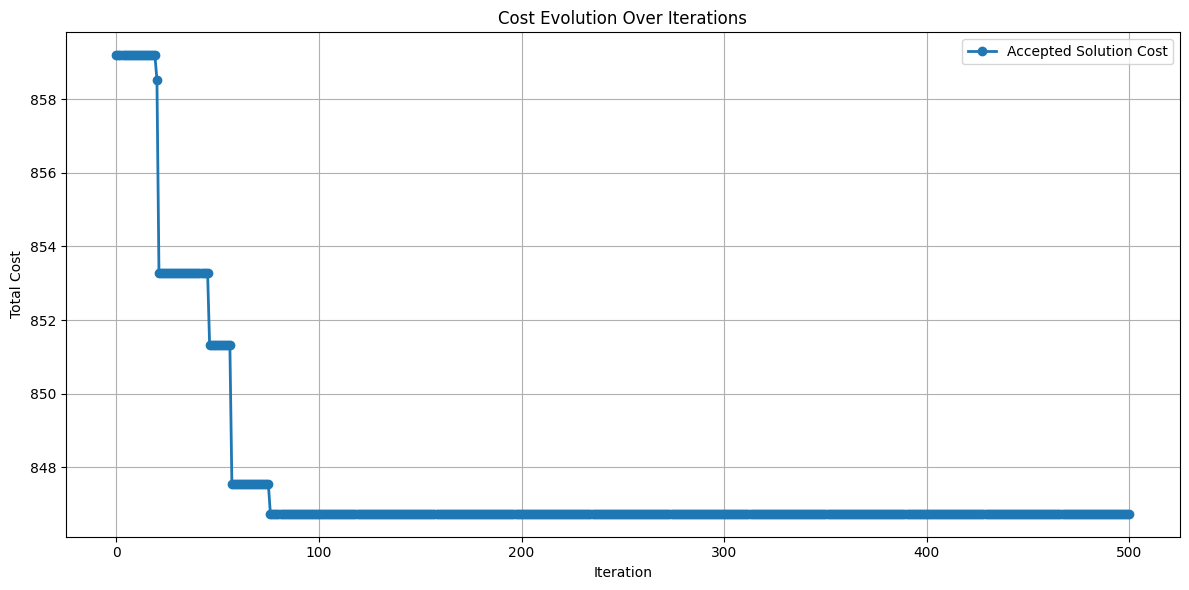

In [148]:
# Plot cost history and computed cost
plt.figure(figsize=(12, 6))
plt.plot(cost_history, marker='o', label='Accepted Solution Cost', linewidth=2)
plt.title("Cost Evolution Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Total Cost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

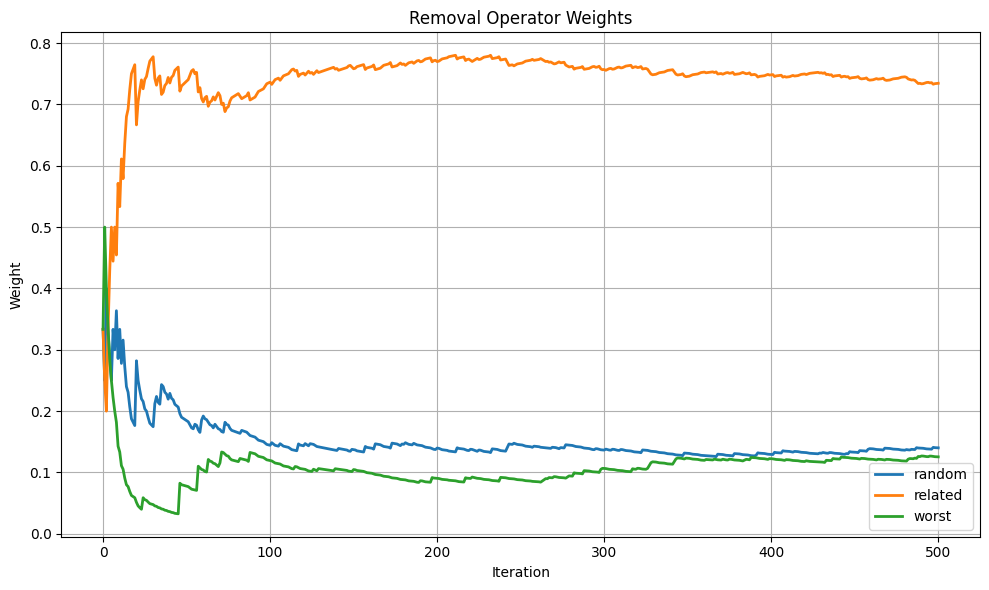

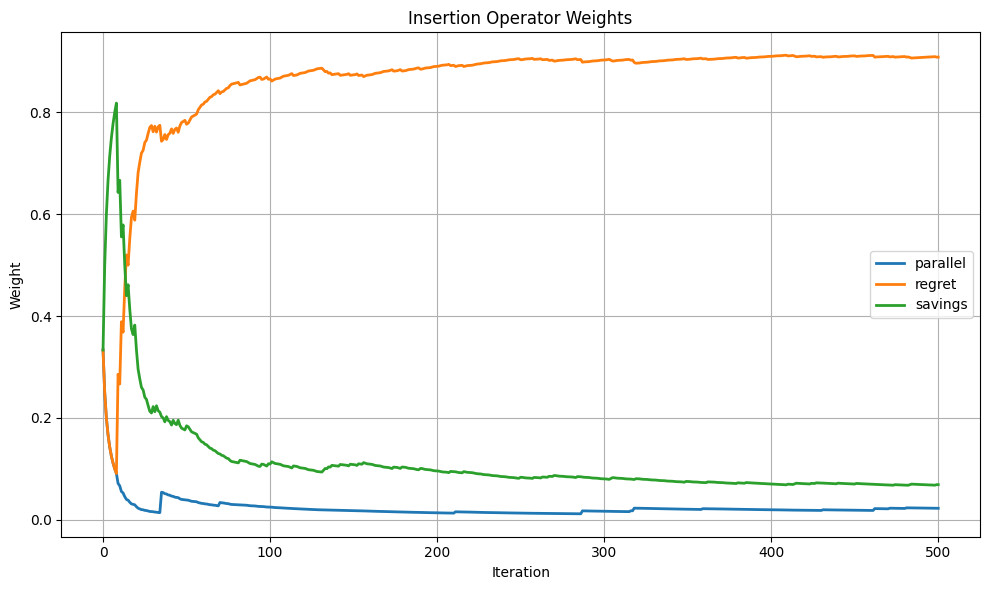

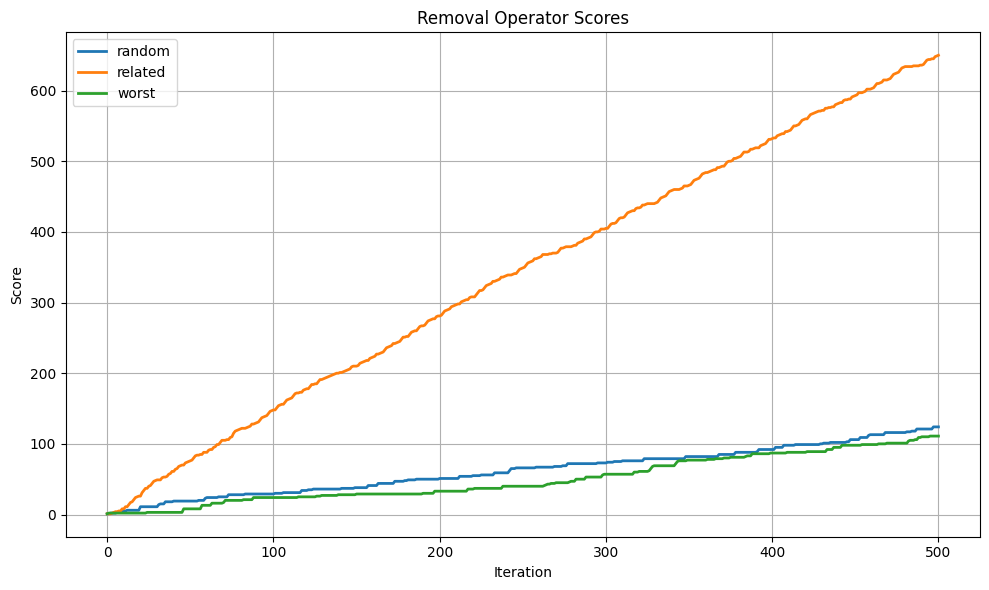

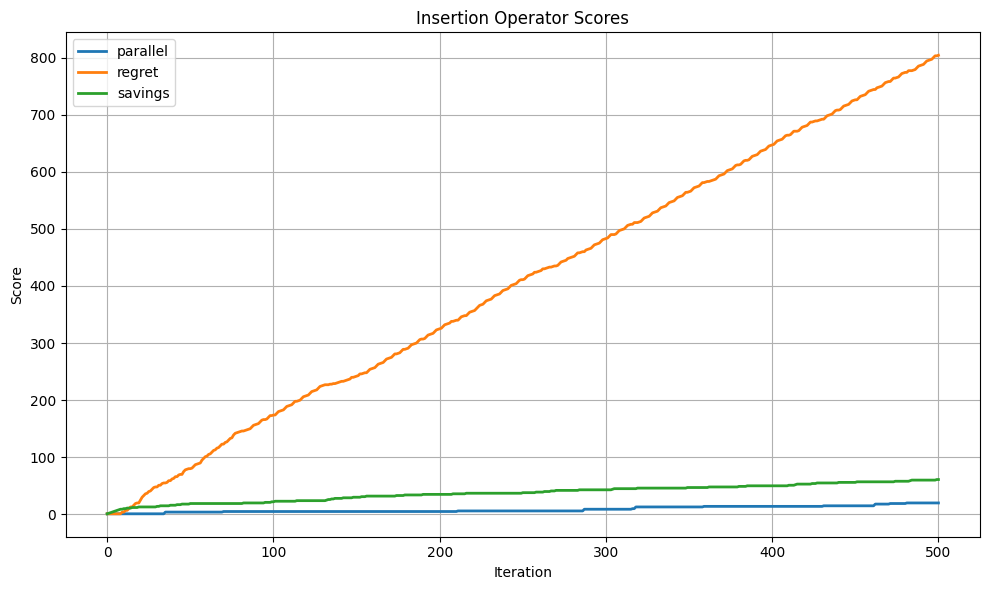

In [149]:
def plot_operator_stats(stat_history, title, ylabel):
    plt.figure(figsize=(10, 6))
    for op, values in stat_history.items():
        plt.plot(values, label=op, linewidth=2)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot operator stats
plot_operator_stats(removal_weights_history, "Removal Operator Weights", "Weight")
plot_operator_stats(insertion_weights_history, "Insertion Operator Weights", "Weight")
plot_operator_stats(removal_scores_history, "Removal Operator Scores", "Score")
plot_operator_stats(insertion_scores_history, "Insertion Operator Scores", "Score")